In [17]:
import os
# –û—Ç–∫–ª—é—á–∞–µ—Ç –≤—Å–µ –ª–æ–≥–∏ TensorFlow (0 - –≤—Å–µ, 1 - –ø—Ä–µ–¥—É–ø—Ä–µ–∂–¥–µ–Ω–∏—è, 2 - –æ—à–∏–±–∫–∏, 3 - –∫—Ä–∏—Ç–∏—á–Ω—ã–µ –æ—à–∏–±–∫–∏)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense
from genre_recommender import preprocess_popularity, recommend_top_movies_by_genres, show_recommendations, get_all_genres
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse import csr_matrix
import implicit
from implicit.als import AlternatingLeastSquares
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import NMF, TruncatedSVD
from scipy.sparse import coo_matrix
# from lightfm import LightFM
# from lightfm.data import Dataset
# from lightfm.evaluation import precision_at_k
from tqdm import tqdm
import json
import os
import math
import glob
import dill
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN

## –ß—Ç–æ –Ω—É–∂–Ω–æ —Å–¥–µ–∞—Ç—å

1. –°–¥–µ–ª–∞—Ç—å —Ç–∞–±–ª–∏—Ü—É populatiry  –Ω–∞ –æ—Å–Ω–æ–≤–µ ratings (—Ç.–µ —Å–¥–µ–ª–∞—Ç—å –¥–∞—Ç–∞—Å–µ—Ç —Å —Å—Ç–æ–ª–±—Ü–∞–º–∏: movieId, ave_rating (–Ω–∞—Ö–æ–¥–∏–º –∫–∞–∫ —Å—Ä–µ–¥–Ω–µ–µ –ø–æ –∫–∞–∂–¥–æ–º—É —Ñ–∏–ª—å–º—É –ø–æ —Ä–µ–π—Ç–∏–Ω–≥—É –∏–∑ imdb –ø–æ imdbId)
2. Content-base:
- –Ω–∞–ø–∏—Å–∞—Ç—å –∫–æ–¥ –≤—ã–¥–∞—á–∏ —Ç–æ–ø -10 –ø–æ populatiry (–≤ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–∏ —Å –∂–∞–Ω—Ä–æ–º)  - –ø—Ä–æ—Å—Ç–æ –≤—ã–¥–∞—á–∞ –ø–æ populatiry + –∂–∞–Ω—Ä(—ã)  (1)
- –Ω–∞–ø–∏—Å–∞—Ç—å –∫–æ–¥ –≤—ã–¥–∞—á–∏ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –ø–æ —Ñ–∏–ª—å–º–∞–º. –ù–∞ 1 —Ñ–∏–ª—å–º - 10 —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π.(–±–µ–∑ —É—á–µ—Ç–∞ —Ä–µ–π—Ç–∏–Ω–≥–∞) -—Ä–µ–∫–æ–º–µ–Ω–¥–∞—à–∫–∞ (2)

3. User-base:
  - –Ω–∞–ø–∏—Å–∞—Ç—å –∫–æ–¥ –≤—ã–¥–∞—á–∏ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –ø–æ —Ñ–∏–ª—å–º—É. –ù–∞ 1 —Ñ–∏–ª—å–º - 10 —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π.(–±–µ–∑ —É—á–µ—Ç–∞ —Ä–µ–π—Ç–∏–Ω–≥–∞) –∏ —Å –∏–∑–º–µ–Ω–µ–Ω–∏–µ–º –≤–µ—Å–æ–≤ –ø–æ —Ç—ç–≥—É-—Ä–µ–∫–æ–º–µ–Ω–¥–∞—à–∫–∞ (3)
  - –Ω–∞–ø–∏—Å–∞—Ç—å –∫–æ–¥ –≤—ã–¥–∞—á–∏ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –ø–æ —Ñ–∏–ª—å–º—É. –ù–∞ 1 —Ñ–∏–ª—å–º - 10 —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π.(—Å —É—á–µ—Ç–æ–º —Ä–µ–π—Ç–∏–Ω–≥–∞) -—Ä–µ–∫–æ–º–µ–Ω–¥–∞—à–∫–∞ (4)

## –†–∞–±–æ—Ç–∞ —Å —é–∑–µ—Ä–∞–º–∏

1. –Æ–∑–µ—Ä –Ω–æ–≤—ã–π –∏ —Ö–æ—á–µ—Ç —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π- –Æ–∑–µ—Ä –≤—ã–±–∏—Ä–∞–µ—Ç –∂–∞–Ω—Ä –∏ –º—ã –≤—ã–¥–∞–µ–º —Ç–æ–ø -5 –ø–æ populatiry (–≤ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–∏ —Å –∂–∞–Ω—Ä–æ–º)
2. –Æ–∑–µ—Ä –ø–æ—Å–º–æ—Ç—Ä–µ–ª –Ω–µ—Å–æ–∫–ª—å–∫–æ —Ñ–∏–ª—å–º–æ–≤ - –ø–æ–¥–±–∏—Ä–∞–µ–º –ø–æ—Ö–æ–∂–∏–π —Ñ–∏–ª—å–º (–∂–∞–Ω—Ä, –∏ —Ç—ç–≥–∏ —Å —É—á–µ—Ç–æ–º –∏—Ö –≤–µ—Å–æ–≤ (relevance))
3. –Æ–∑–µ—Ä –ø–æ—Å–º–æ—Ç—Ä–µ–ª –Ω–µ—Å–∫–æ–ª—å–∫–æ —Ñ–∏–ª—å–º–æ–≤ –∏ –ø–æ—Å—Ç–∞–≤–∏–ª —Ä–µ–π—Ç–∏–Ω–≥ –º–µ–Ω–µ–µ 5 —Ä–∞–∑ –Ω–æ –±–æ–ª—å—à–µ 0. –§–∏–∫—Å–∏—Ä—É–µ–º —Ç—ç–≥ —Ñ–∏–ª—å–º–æ–≤ –Ω–∞ –∫–æ—Ç–æ—Ä—ã–µ –±—ã–ª –ø–æ—Å—Ç–∞–≤–ª–µ–Ω —Ä–µ–π—Ç–∏–Ω–≥. –ò –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –æ—Ü–µ–Ω–∫–∏ —É–º–µ–Ω—å—à–∞–µ–º–∏–ª–∏ —É–≤–µ–ª–∏—á–∏–≤–∞–µ–º –≤–µ—Å–∞ –∂–∞–Ω—Ä–æ–≤/—Ç—ç–≥–æ–≤ –ø—Ä–æ–ø–æ—Ä—Ü–∏–æ–Ω–∞–ª—å–Ω–æ –æ—Ü–µ–Ω–∫–µ.
4. –Æ–∑–µ—Ä –ø–æ—Å–º–æ—Ç—Ä–µ–ª –Ω–µ—Å–∫–æ–ª—å–∫–æ —Ñ–∏–ª—å–º–æ–≤ –∏ –ø–æ—Å—Ç–∞–≤–∏–ª —Ä–µ–π—Ç–∏–Ω–≥ 5+—Ä–∞–∑  - –ø–æ–¥–±–∏—Ä–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ ( –≤ —Å–æ–æ—Ç–≤–µ—Ç–≤–∏–∏ —Å –µ–≥–æ —Ä–µ–π—Ç–∏–Ω–≥–∞–º–∏)

# 1.—Ç–æ–ø -10 –ø–æ populatiry (–≤ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–∏ —Å –∂–∞–Ω—Ä–æ–º) - –ø—Ä–æ—Å—Ç–æ –≤—ã–¥–∞—á–∞ –ø–æ populatiry + –∂–∞–Ω—Ä(—ã) (1)

In [16]:
popularity_df = preprocess_popularity(ratings)

# –ù–µ–ø–æ—Å—Ä–µ–¥—Å—Ç–≤–µ–Ω–Ω–æ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏
recommend_top_movies_by_genres("Action", "Adventure", movies_df=movies, popularity_df=popularity_df)

title  \
44066                            Band of Brothers (2001)   
1930         Seven Samurai (Shichinin no samurai) (1954)   
41020                        Over the Garden Wall (2013)   
2867                                   Fight Club (1999)   
82617         Spider-Man: Across the Spider-Verse (2023)   
5509   Spirited Away (Sen to Chihiro no kamikakushi) ...   
55378           Spider-Man: Into the Spider-Verse (2018)   
12221                            Dark Knight, The (2008)   
887                            North by Northwest (1959)   
5905                 City of God (Cidade de Deus) (2002)   

                                          genres  ave_rating  rating_count  \
44066                           Action|Drama|War    4.423986          2835   
1930                      Action|Adventure|Drama    4.250818         17120   
41020                  Adventure|Animation|Drama    4.256993          1430   
2867                 Action|Crime|Drama|Thriller    4.236019         86207   
82617          Action|Adventure|Animation|Sci-Fi    4.252841           528   
5509                 Adventure|Animation|Fantasy    4.226035         35375   
55378          Action|Adventure|Animation|Sci-Fi    4.192053         10885   
12221                    Action|Crime|Drama|IMAX    4.187539         65349   
887    Action|Adventure|Mystery|Romance|Thriller    4.187337         21883   
5905       Action|Adventure|Crime|Drama|Thriller    4.183597         27209   

       weighted_rating  
44066         4.419025  
1930          4.250095  
41020         4.248352  
2867          4.235877  
82617         4.229790  
5509          4.225692  
55378         4.190971  
12221         4.187359  
887           4.186801  
5905          4.183167

In [25]:
# –ò–Ω—Ç–µ—Ä–∞–∫—Ç–∏–≤–Ω—ã–π —Ä–µ–∂–∏–º 
show_recommendations(movies_df=movies, ratings_df=ratings)

## 2. Content-base:

In [4]:
# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö

movies = pd.read_csv('content/films/movies.csv')
ratings = pd.read_csv('content/films/ratings.csv')
tags = pd.read_csv('content/films/tags.csv')
genome_tags = pd.read_csv('content/films/genome-tags.csv')
genome_scores = pd.read_csv('content/films/genome-scores.csv')

# –ü—Ä–æ–≤–µ—Ä–∏–º —Ä–∞–∑–º–µ—Ä—ã
print("movies:", movies.shape)
print("ratings:", ratings.shape)
print("tags:", tags.shape)
print("genome_tags:", genome_tags.shape)
print("genome_scores:", genome_scores.shape)

movies: (86537, 3)
ratings: (33832162, 4)
tags: (2328315, 4)
genome_tags: (1128, 2)
genome_scores: (18472128, 3)


In [6]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º genome_scores –≤ —à–∏—Ä–æ–∫—É—é —Ç–∞–±–ª–∏—Ü—É: movieId √ó tagId
movie_tag_matrix = genome_scores.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)

# –î–æ–±–∞–≤–∏–º –∫ movie_tag_matrix –Ω–∞–∑–≤–∞–Ω–∏—è —Ç–µ–≥–æ–≤
tag_id_to_name = genome_tags.set_index('tagId')['tag']
movie_tag_matrix.columns = movie_tag_matrix.columns.map(tag_id_to_name)

# –ü—Ä–æ–≤–µ—Ä–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
print("movie_tag_matrix shape:", movie_tag_matrix.shape)
movie_tag_matrix.head(3)

movie_tag_matrix shape: (16376, 1128)


tagId       007  007 (series)  18th century    1920s    1930s   1950s  \
movieId                                                                 
1        0.0320       0.02225       0.07000  0.05900  0.12300  0.1310   
2        0.0325       0.03200       0.04050  0.05100  0.10050  0.0635   
3        0.0415       0.05525       0.02125  0.07225  0.05125  0.0440   

tagId      1960s    1970s    1980s  19th century  ...  world politics  \
movieId                                           ...                   
1        0.06175  0.19550  0.26625       0.03300  ...         0.04125   
2        0.19825  0.07525  0.09750       0.06325  ...         0.04100   
3        0.03000  0.10375  0.02300       0.03250  ...         0.06175   

tagId    world war i  world war ii  writer's life  writers  writing    wuxia  \
movieId                                                                        
1            0.01550       0.03775        0.03500  0.11525  0.04350  0.04050   
2            0.02025       0.01100        0.01875  0.13425  0.01850  0.01825   
3            0.01825       0.02375        0.01700  0.12400  0.02775  0.01600   

tagId       wwii   zombie  zombies  
movieId                             
1        0.03300  0.07700  0.01825  
2        0.00825  0.08750  0.01375  
3        0.01325  0.10075  0.01800  

[3 rows x 1128 columns]

## –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è

In [8]:
scaler = MinMaxScaler()
movie_vectors_scaled = scaler.fit_transform(movie_tag_matrix)

print("Scaled shape:", movie_vectors_scaled.shape)

Scaled shape: (16376, 1128)


In [12]:
input_dim = movie_vectors_scaled.shape[1]  # 1128
encoding_dim = 64  # –º–æ–∂–Ω–æ –∏–∑–º–µ–Ω–∏—Ç—å –Ω–∞ 128 –∏–ª–∏ 32

# –í—Ö–æ–¥–Ω–æ–π —Å–ª–æ–π
input_layer = Input(shape=(input_dim,))

# –ö–æ–¥–∏—Ä–æ–≤—â–∏–∫ (encoder)
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# –î–µ–∫–æ–¥–∏—Ä–æ–≤—â–∏–∫ (decoder)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# –ú–æ–¥–µ–ª—å –∞–≤—Ç–æ—ç–Ω–∫–æ–¥–µ—Ä–∞
autoencoder = Model(input_layer, decoded)

# –ú–æ–¥–µ–ª—å —ç–Ω–∫–æ–¥–µ—Ä–∞ (–¥–ª—è –∏–∑–≤–ª–µ—á–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤)
encoder = Model(input_layer, encoded)

# –ö–æ–º–ø–∏–ª—è—Ü–∏—è
autoencoder.compile(optimizer='adam', loss='mse')

# –û–±—É—á–µ–Ω–∏–µ
history = autoencoder.fit(
    movie_vectors_scaled, movie_vectors_scaled,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.1
)

Epoch 1/20
58/58 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 34ms/step - loss: 0.0755 - val_loss: 0.0255
Epoch 2/20
58/58 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 30ms/step - loss: 0.0299 - val_loss: 0.0247
Epoch 3/20
58/58 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 30ms/step - loss: 0.0291 - val_loss: 0.0244
Epoch 4/20
58/58 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 29ms/step - loss: 0.0287 - val_loss: 0.0231
Epoch 5/20
58/58 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 29ms/step - loss: 0.0230 - val_loss: 0.0065
Epoch 6/20
58/58 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 29ms/step - loss: 0.0117 - val_loss: 0.0056
Epoch 7/20
58/58 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 35ms/step - loss: 0.0102 - val_loss: 0.0051
Epoch 8/20
58/58 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 31ms/step - loss: 0.0088 - val_loss: 0.0050


In [13]:
# –ü–æ–ª—É—á–∞–µ–º —Å–∂–∞—Ç—ã–µ –≤–µ–∫—Ç–æ—Ä—ã
movie_vectors_reduced = encoder.predict(movie_vectors_scaled)

# –ü—Ä–æ–≤–µ—Ä–∏–º —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å
print("Reduced shape:", movie_vectors_reduced.shape)


512/512 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 2ms/step
Reduced shape: (16376, 64)


In [ ]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ DataFrame –∏ –¥–æ–±–∞–≤–∏–º movieId
movie_vectors_df = pd.DataFrame(movie_vectors_reduced)
movie_vectors_df['movieId'] = movie_tag_matrix.index.values



In [14]:
# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Å –∏–Ω–¥–µ–∫—Å–∞–º–∏
np.savez_compressed('content/films/movie_vectors_reduced.npz',
                    vectors=movie_vectors_reduced,
                    movie_ids=movie_tag_matrix.index.values)

print("–°–∂–∞—Ç—ã–µ –≤–µ–∫—Ç–æ—Ä—ã —Ñ–∏–ª—å–º–æ–≤ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ movie_vectors_reduced.npz")

–°–∂–∞—Ç—ã–µ –≤–µ–∫—Ç–æ—Ä—ã —Ñ–∏–ª—å–º–æ–≤ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ movie_vectors_reduced.npz


In [19]:
data = np.load('content/films/movie_vectors_reduced.npz')
movie_vectors_reduced = data['vectors']
movie_ids = data['movie_ids']


In [4]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è 10 —Å–∞–º—ã—Ö –ø–æ—Ö–æ–∂–∏—Ö —Ñ–∏–ª—å–º–æ–≤
def get_similar_movies(movie_id, movie_vectors_reduced, top_n=10):
    cosine_sim = cosine_similarity(movie_vectors_reduced)  # –ö–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ
    movie_index = movie_id - 1  # –ò–Ω–¥–µ–∫—Å—ã –Ω–∞—á–∏–Ω–∞—é—Ç—Å—è —Å 0, –∞ movie_id - —Å 1
    sim_scores = list(enumerate(cosine_sim[movie_index]))  # –°–ø–∏—Å–æ–∫ —Å—Ö–æ–¥—Å—Ç–≤–∞
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # –°–æ—Ä—Ç–∏—Ä—É–µ–º
    return sim_scores[1:top_n+1]  # –¢–æ–ø-N —Å—Ö–æ–∂–∏—Ö —Ñ–∏–ª—å–º–æ–≤


In [ ]:
def recommend_movies_with_strict_genres_filter(movie_ids, top_n=10, internal_top_n=50, mode='custom'):
    all_recommendations = []

    for movie_id in movie_ids:
        original_movie_row = movies[movies['movieId'] == movie_id]
        if original_movie_row.empty:
            continue
        
        original_movie_title = original_movie_row['title'].values[0]
        original_movie_genres = original_movie_row['genres'].values[0]
        original_genres_set = set(original_movie_genres.split('|'))

        print(f"–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: {movie_id} (–ù–∞–∑–≤–∞–Ω–∏–µ: {original_movie_title}) (–ñ–∞–Ω—Ä—ã: {original_movie_genres})")

        # –í—ã–±–æ—Ä –º–µ—Ç–æ–¥–∞ –ø–æ–ª—É—á–µ–Ω–∏—è –ø–æ—Ö–æ–∂–∏—Ö —Ñ–∏–ª—å–º–æ–≤
        if mode == 'knn':
            similar_movies = get_similar_movies_knn(movie_id, movie_vectors_reduced, top_n=internal_top_n)
        else:
            similar_movies = get_similar_movies(movie_id, movie_vectors_reduced, top_n=internal_top_n)

        filtered_similar_movies = []
        for idx, score in similar_movies:
            movie_row = movies.iloc[idx]
            movie_title = movie_row['title']
            movie_genres = movie_row['genres']

            if pd.isna(movie_title) or pd.isna(movie_genres):
                continue

            movie_genres_set = set(movie_genres.split('|'))

            # –ó–∞–Ω—É–ª—è–µ–º score, –µ—Å–ª–∏ –Ω–µ—Ç –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏–π –ø–æ –∂–∞–Ω—Ä–∞–º
            if not original_genres_set.intersection(movie_genres_set):
                score = 0

            filtered_similar_movies.append({
                'movie_id': movies.iloc[idx]['movieId'],
                'title': movie_title,
                'genres': movie_genres,
                'similarity_score': score
            })

        # –ü—Ä–∏–º–µ–Ω—è–µ–º –≤–∑–≤–µ—à–µ–Ω–Ω—ã–µ –±–∞–ª–ª—ã
        for i, rec in enumerate(filtered_similar_movies):
            final_weight = rec['similarity_score']
            if i == 0:
                rec['weight'] = final_weight + 20
            elif i == 1:
                rec['weight'] = final_weight + 12
            elif i == 2:
                rec['weight'] = final_weight + 8
            elif i == 3:
                rec['weight'] = final_weight + 5
            elif i == 4:
                rec['weight'] = final_weight + 3
            else:
                rec['weight'] = final_weight + 1

        all_recommendations.extend(filtered_similar_movies)

    # –§–∏–Ω–∞–ª—å–Ω—ã–π —Ä–∞—Å—á—ë—Ç –±–∞–ª–ª–æ–≤
    recommendations_df = pd.DataFrame(all_recommendations)
    if recommendations_df.empty:
        return pd.DataFrame(columns=['movie_id', 'title', 'genres', 'weight'])

    final_scores = recommendations_df.groupby('movie_id').agg({'weight': 'sum'}).reset_index()
    final_recommendations_df = final_scores.sort_values('weight', ascending=False).head(top_n)

    final_recommendations_df = final_recommendations_df.merge(
        movies[['movieId', 'title', 'genres']],
        left_on='movie_id',
        right_on='movieId',
        how='left'
    ).dropna(subset=['title', 'genres'])

    return final_recommendations_df[['movie_id', 'title', 'genres', 'weight']]

In [22]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—á–µ—Ç–∞ —Å—Ö–æ–¥—Å—Ç–≤–∞ –∂–∞–Ω—Ä–æ–≤
def calculate_genre_similarity(genre1, genre2):
    genres1 = set(genre1.split('|'))
    genres2 = set(genre2.split('|'))
    
    # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏–µ –∂–∞–Ω—Ä–æ–≤
    common_genres = genres1.intersection(genres2)
    
    # –°—Ö–æ–∂–µ—Å—Ç—å –±—É–¥–µ—Ç —Ä–∞–≤–Ω–∞ –æ—Ç–Ω–æ—à–µ–Ω–∏—é –æ–±—â–µ–≥–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –∂–∞–Ω—Ä–æ–≤ –∫ –æ–±—â–µ–º—É –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –∂–∞–Ω—Ä–æ–≤
    return len(common_genres) / len(genres1.union(genres2))

In [23]:
# –ü—Ä–∏–º–µ—Ä: —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID = 1
movie_ids_to_check = [1, 10, 100]
top_n = 10  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π
final_recommendations_df = recommend_movies_with_strict_genres_filter(movie_ids_to_check, top_n)


# –í—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
final_recommendations_df

–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 1 (–ù–∞–∑–≤–∞–Ω–∏–µ: Toy Story (1995)) (–ñ–∞–Ω—Ä—ã: Adventure|Animation|Children|Comedy|Fantasy)
–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 10 (–ù–∞–∑–≤–∞–Ω–∏–µ: GoldenEye (1995)) (–ñ–∞–Ω—Ä—ã: Action|Adventure|Thriller)
–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 100 (–ù–∞–∑–≤–∞–Ω–∏–µ: City Hall (1996)) (–ñ–∞–Ω—Ä—ã: Drama|Thriller)


movie_id                                              title  \
0      1591                                       Spawn (1997)   
1      4533              Return of the Living Dead, The (1985)   
2      6656                 Attack of the Puppet People (1958)   
3      2794  European Vacation (aka National Lampoon's Euro...   
4      2626                           Edge of Seventeen (1998)   
5      5786                                Paid in Full (2002)   
6      2881                             Double Jeopardy (1999)   
7      8874                           Shaun of the Dead (2004)   
8      2912                                  Limey, The (1999)   
9       167                               Feast of July (1995)   

                             genres     weight  
0  Action|Adventure|Sci-Fi|Thriller  20.996246  
1              Comedy|Horror|Sci-Fi  20.987832  
2                     Horror|Sci-Fi  20.000000  
3          Adventure|Comedy|Romance  12.995582  
4              Comedy|Drama|Romance  12.993158  
5                      Action|Drama  12.000000  
6       Action|Crime|Drama|Thriller   8.994554  
7                     Comedy|Horror   8.000000  
8              Crime|Drama|Thriller   8.000000  
9                             Drama   5.991889

In [24]:
# –ü—Ä–∏–º–µ—Ä: —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID = 1
movie_ids_to_check = [1]
top_n = 10  # –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π
final_recommendations_df_2 = recommend_movies_with_strict_genres_filter(movie_ids_to_check, top_n)


# –í—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
final_recommendations_df_2

–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 1 (–ù–∞–∑–≤–∞–Ω–∏–µ: Toy Story (1995)) (–ñ–∞–Ω—Ä—ã: Adventure|Animation|Children|Comedy|Fantasy)


movie_id                                              title  \
0      4533              Return of the Living Dead, The (1985)   
1      5786                                Paid in Full (2002)   
2      2912                                  Limey, The (1999)   
3      2196                                   Knock Off (1998)   
4     44655  Trial of Joan of Arc, The (Proc√®s de Jeanne d'...   
5     53318                                    Cashback (2006)   
6      7370                            A Foreign Affair (2003)   
7     72612                          Fly, The (L√©gy, A) (1980)   
8     54910  Behind the Mask: The Rise of Leslie Vernon (2006)   
9     59143                               Super High Me (2007)   

                   genres     weight  
0    Comedy|Horror|Sci-Fi  20.987832  
1            Action|Drama  12.000000  
2    Crime|Drama|Thriller   8.000000  
3                  Action   5.000000  
4               Drama|War   3.000000  
5    Comedy|Drama|Romance   1.971462  
6    Comedy|Drama|Romance   1.970418  
7        Animation|Comedy   1.970037  
8  Comedy|Horror|Thriller   1.965568  
9      Comedy|Documentary   1.965460

## KNN

KNN (K-Nearest Neighbors)

–ü—Ä–∏–Ω—Ü–∏–ø —Ä–∞–±–æ—Ç—ã: KNN ‚Äî —ç—Ç–æ –º–µ—Ç–æ–¥, –æ—Å–Ω–æ–≤–∞–Ω–Ω—ã–π –Ω–∞ –∏–¥–µ–µ –ø–æ–∏—Å–∫–∞ –±–ª–∏–∂–∞–π—à–∏—Ö —Å–æ—Å–µ–¥–µ–π. –î–ª—è —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ —Ç–æ–≤–∞—Ä–æ–≤ –∏–ª–∏ —Ñ–∏–ª—å–º–æ–≤ –æ–Ω –∏—â–µ—Ç –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –∏–ª–∏ —ç–ª–µ–º–µ–Ω—Ç—ã, –∫–æ—Ç–æ—Ä—ã–µ –Ω–∞–∏–±–æ–ª–µ–µ –ø–æ—Ö–æ–∂–∏ –Ω–∞ –∑–∞–¥–∞–Ω–Ω–æ–≥–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è –∏–ª–∏ —Ñ–∏–ª—å–º. –û—Å–Ω–æ–≤–Ω—ã–µ —à–∞–≥–∏:
–ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö: –ú—ã –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ–º –∫–∞–∂–¥—ã–π —Ñ–∏–ª—å–º –∏–ª–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è –≤ –≤–∏–¥–µ –≤–µ–∫—Ç–æ—Ä–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–Ω–∞–ø—Ä–∏–º–µ—Ä, —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º TF-IDF, –º–µ—Ç–æ–∫ –∂–∞–Ω—Ä–∞ –∏–ª–∏ –¥—Ä—É–≥–∏—Ö —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫). –†–∞—Å—Å—Ç–æ—è–Ω–∏–µ –º–µ–∂–¥—É –æ–±—ä–µ–∫—Ç–∞–º–∏: –ß—Ç–æ–±—ã –Ω–∞–π—Ç–∏ ¬´–ø–æ—Ö–æ–∂–∏–µ¬ª –æ–±—ä–µ–∫—Ç—ã, –º—ã –∏–∑–º–µ—Ä—è–µ–º —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ (–∏–ª–∏ —Å—Ö–æ–∂–µ—Å—Ç—å) –º–µ–∂–¥—É –≤–µ–∫—Ç–æ—Ä–∞–º–∏ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —Ç–∞–∫–∏—Ö –º–µ—Ç—Ä–∏–∫, –∫–∞–∫ –µ–≤–∫–ª–∏–¥–æ–≤–æ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ, –∫–æ—Å–∏–Ω—É—Å–Ω–∞—è —Å—Ö–æ–∂–µ—Å—Ç—å –∏ –¥—Ä—É–≥–∏–µ.
–ü–æ–∏—Å–∫ –±–ª–∏–∂–∞–π—à–∏—Ö —Å–æ—Å–µ–¥–µ–π: –î–ª—è –∫–æ–Ω–∫—Ä–µ—Ç–Ω–æ–≥–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è –∏–ª–∏ —Ñ–∏–ª—å–º–∞ KNN –Ω–∞—Ö–æ–¥–∏—Ç –±–ª–∏–∂–∞–π—à–∏—Ö —Å–æ—Å–µ–¥–µ–π (—Ñ–∏–ª—å–º–æ–≤ –∏–ª–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π), –æ—Å–Ω–æ–≤—ã–≤–∞—è—Å—å –Ω–∞ –≤—ã–±—Ä–∞–Ω–Ω–æ–π –º–µ—Ç—Ä–∏–∫–µ —Å—Ö–æ–¥—Å—Ç–≤–∞.
–†–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏—è: –î–ª—è —Ñ–∏–ª—å–º–∞ –∏–ª–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è –Ω–∞ –æ—Å–Ω–æ–≤–µ —Å—Ö–æ–∂–µ—Å—Ç–∏ —Å –¥—Ä—É–≥–∏–º–∏ –æ–±—ä–µ–∫—Ç–∞–º–∏ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ç–æ—Ä –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–µ—Ç, –∫–∞–∫–∏–µ —ç–ª–µ–º–µ–Ω—Ç—ã –æ–Ω –º–æ–≥ –±—ã "–Ω—Ä–∞–≤–∏—Ç—å—Å—è" –∏–ª–∏ –∫–∞–∫–∏–µ —Ñ–∏–ª—å–º—ã –º–æ–≥—É—Ç –µ–º—É –ø–æ–¥–æ–π—Ç–∏. –§–∏–∑–∏—á–µ—Å–∫–∏–π —Å–º—ã—Å–ª: –ú–æ–¥–µ–ª—å –∏—â–µ—Ç –±–ª–∏–∂–∞–π—à–∏—Ö —Å–æ—Å–µ–¥–µ–π –Ω–∞ –æ—Å–Ω–æ–≤–µ —Å—Ö–æ–¥—Å—Ç–≤–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤. –ù–∞–ø—Ä–∏–º–µ—Ä, –µ—Å–ª–∏ —Ñ–∏–ª—å–º –ø–æ—Ö–æ–∂ –Ω–∞ –¥—Ä—É–≥–∏–µ –ø–æ –∂–∞–Ω—Ä–∞–º, –∞–∫—Ç—ë—Ä–∞–º, —Ä–µ–π—Ç–∏–Ω–≥—É, —Ç–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—é –º–æ–≥—É—Ç –ø–æ—Ä–µ–∫–æ–º–µ–Ω–¥–æ–≤–∞—Ç—å —ç—Ç–∏ —Ñ–∏–ª—å–º—ã. KNN –º–æ–∂–Ω–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–∏—Ç—å –∫–∞–∫ —Å–ø–æ—Å–æ–± –ø–æ–∏—Å–∫ –ø–æ—Ö–æ–∂–∏—Ö –æ–±—ä–µ–∫—Ç–æ–≤ –≤ –±–æ–ª—å—à–æ–º –º–Ω–æ–∂–µ—Å—Ç–≤–µ –¥–∞–Ω–Ω—ã—Ö.
–ü—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–∞: –ü—Ä–æ—Å—Ç–æ—Ç–∞ –∏ –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∏—Ä—É–µ–º–æ—Å—Ç—å. –ú–æ–¥–µ–ª—å –Ω–µ —Ç—Ä–µ–±—É–µ—Ç –æ–±—É—á–µ–Ω–∏—è, –ø–æ—Ç–æ–º—É —á—Ç–æ –æ–Ω–∞ –ø—Ä–æ—Å—Ç–æ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç –¥–∞–Ω–Ω—ã–µ –¥–ª—è –ø–æ–∏—Å–∫–∞ –±–ª–∏–∂–∞–π—à–∏—Ö —Å–æ—Å–µ–¥–µ–π.
–ù–µ–¥–æ—Å—Ç–∞—Ç–∫–∏: –í—ã—Å–æ–∫–∞—è –≤—ã—á–∏—Å–ª–∏—Ç–µ–ª—å–Ω–∞—è –Ω–∞–≥—Ä—É–∑–∫–∞ –Ω–∞ –±–æ–ª—å—à–∏—Ö –¥–∞–Ω–Ω—ã—Ö, –æ—Å–æ–±–µ–Ω–Ω–æ –ø—Ä–∏ –ø–æ–∏—Å–∫–µ –ø–æ –≤—Å–µ–π –±–∞–∑–µ. –ù–µ –≤—Å–µ–≥–¥–∞ –ø–æ–¥—Ö–æ–¥–∏—Ç –¥–ª—è –±–æ–ª–µ–µ —Å–ª–æ–∂–Ω—ã—Ö –∏–ª–∏ —Å–∫—Ä—ã—Ç—ã—Ö –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–µ–π –º–µ–∂–¥—É –æ–±—ä–µ–∫—Ç–∞–º–∏.


In [30]:
knn_model = NearestNeighbors(n_neighbors=51, metric='cosine')  # 50 + 1, –ø–æ—Ç–æ–º—É —á—Ç–æ –ø–µ—Ä–≤—ã–π –±—É–¥–µ—Ç —Å–∞–º —Ñ–∏–ª—å–º
knn_model.fit(movie_vectors_reduced)

NearestNeighbors(metric='cosine', n_neighbors=51)

In [31]:
def get_similar_movies_knn(movie_id, movie_vectors, top_n=50):
    # –ü–æ–ª—É—á–∞–µ–º –∏–Ω–¥–µ–∫—Å —Ñ–∏–ª—å–º–∞
    movie_index = movies[movies['movieId'] == movie_id].index[0]

    # –ù–∞—Ö–æ–¥–∏–º –±–ª–∏–∂–∞–π—à–∏–µ —Ñ–∏–ª—å–º—ã
    distances, indices = knn_model.kneighbors([movie_vectors[movie_index]], n_neighbors=top_n+1)

    # –í–æ–∑–≤—Ä–∞—â–∞–µ–º —Å–ø–∏—Å–æ–∫ (–∏–Ω–¥–µ–∫—Å, 1 - —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ) ‚Äî –∫—Ä–æ–º–µ —Å–∞–º–æ–≥–æ —Å–µ–±—è
    similar_movies = []
    for i in range(1, len(indices[0])):  # –ø—Ä–æ–ø—É—Å–∫–∞–µ–º 0-–π —ç–ª–µ–º–µ–Ω—Ç (—Å–∞–º —Ñ–∏–ª—å–º)
        idx = indices[0][i]
        similarity_score = 1 - distances[0][i]  # —á–µ–º –º–µ–Ω—å—à–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ, —Ç–µ–º –≤—ã—à–µ —Å—Ö–æ–¥—Å—Ç–≤–æ
        similar_movies.append((idx, similarity_score))
    
    return similar_movies

In [32]:
movie_ids_to_check = [1, 10, 100]

recommend_movies_with_strict_genres_filter(
    movie_ids=movie_ids_to_check,
    top_n=10,
    internal_top_n=50,
    mode='knn'
)

–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 1 (–ù–∞–∑–≤–∞–Ω–∏–µ: Toy Story (1995)) (–ñ–∞–Ω—Ä—ã: Adventure|Animation|Children|Comedy|Fantasy)
–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 10 (–ù–∞–∑–≤–∞–Ω–∏–µ: GoldenEye (1995)) (–ñ–∞–Ω—Ä—ã: Action|Adventure|Thriller)
–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 100 (–ù–∞–∑–≤–∞–Ω–∏–µ: City Hall (1996)) (–ñ–∞–Ω—Ä—ã: Drama|Thriller)


movie_id                                              title  \
0      1591                                       Spawn (1997)   
1      4533              Return of the Living Dead, The (1985)   
2      1184                                Mediterraneo (1991)   
3      2794  European Vacation (aka National Lampoon's Euro...   
4      5786                                Paid in Full (2002)   
5     65204                         Chandu the Magician (1932)   
6      2881                             Double Jeopardy (1999)   
7      1141                    Last Call (Hoogste tijd) (1995)   
8      2912                                  Limey, The (1999)   
9      2237                              Without Limits (1998)   

                             genres     weight  
0  Action|Adventure|Sci-Fi|Thriller  20.996246  
1              Comedy|Horror|Sci-Fi  20.987832  
2                      Comedy|Drama  20.977005  
3          Adventure|Comedy|Romance  12.995582  
4                      Action|Drama  12.000000  
5   Action|Adventure|Fantasy|Sci-Fi  12.000000  
6       Action|Crime|Drama|Thriller   8.994554  
7                             Drama   8.974602  
8              Crime|Drama|Thriller   8.000000  
9                             Drama   5.974312

## –ü–æ–ø—Ä–æ–±—É–µ–º AgglomerativeClustering

In [45]:
# 1. –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è
def cluster_movies(movie_vectors_reduced, n_clusters=100):
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clustering_model.fit_predict(movie_vectors_reduced)
    return cluster_labels

In [46]:
def recommend_movies_by_cluster_filtered(movie_ids, movie_vectors_reduced, movies, cluster_labels, top_n=10):
    all_recommendations = []

    for movie_id in movie_ids:
        try:
            # –ü–æ–ª—É—á–∞–µ–º –∏–Ω–¥–µ–∫—Å —Ñ–∏–ª—å–º–∞
            movie_idx = movies[movies['movieId'] == movie_id].index[0]
            movie_title = movies.iloc[movie_idx]['title']
            movie_genres = set(movies.iloc[movie_idx]['genres'].split('|'))

            # –ü–æ–ª—É—á–∞–µ–º –∫–ª–∞—Å—Ç–µ—Ä
            cluster_label = cluster_labels[movie_idx]
            same_cluster_indices = np.where(cluster_labels == cluster_label)[0]
            same_cluster_indices = same_cluster_indices[same_cluster_indices != movie_idx]

            if len(same_cluster_indices) == 0:
                continue

            # –ï–≤–∫–ª–∏–¥–æ–≤—ã —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è
            distances = euclidean_distances(
                movie_vectors_reduced[movie_idx].reshape(1, -1),
                movie_vectors_reduced[same_cluster_indices]
            )[0]
            similarities = 1 / (1 + distances)

            for idx, score in zip(same_cluster_indices, similarities):
                title = movies.iloc[idx]['title']
                genres = movies.iloc[idx]['genres']
                genres_set = set(genres.split('|'))

                if pd.isna(title) or pd.isna(genres):
                    continue

                if not movie_genres.intersection(genres_set):
                    score = 0

                all_recommendations.append({
                    'movie_id': movies.iloc[idx]['movieId'],
                    'title': title,
                    'genres': genres,
                    'similarity_score': score
                })
        except IndexError:
            continue

    # –ê–≥—Ä–µ–≥–∏—Ä—É–µ–º –∏ —Å–æ—Ä—Ç–∏—Ä—É–µ–º
    all_recommendations_df = pd.DataFrame(all_recommendations)
    if all_recommendations_df.empty:
        return all_recommendations_df

    all_recommendations_df = all_recommendations_df.groupby(['movie_id', 'title', 'genres']).agg({'similarity_score': 'sum'}).reset_index()
    all_recommendations_df = all_recommendations_df.sort_values('similarity_score', ascending=False).head(top_n)

    # –î–æ–±–∞–≤–∏–º –≤–µ—Å–∞ 
    weights = [20, 12, 8, 5, 3, 2, 2, 1, 1, 1]
    all_recommendations_df['weight'] = weights[:len(all_recommendations_df)]

    return all_recommendations_df

In [47]:
# –ö–ª–∞—Å—Ç–µ—Ä–∏–∑—É–µ–º —Ñ–∏–ª—å–º—ã
cluster_labels = cluster_movies(movie_vectors_reduced, n_clusters=100)

# –†–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Å–ø–∏—Å–∫–∞ —Ñ–∏–ª—å–º–æ–≤
movie_ids_to_check = [1, 10, 100]
recommend_movies_by_cluster_filtered(movie_ids_to_check, movie_vectors_reduced, movies, cluster_labels, top_n=10)


movie_id                                              title  \
52       1591                                       Spawn (1997)   
96       2794  European Vacation (aka National Lampoon's Euro...   
103      2881                             Double Jeopardy (1999)   
132      3696                         Night of the Creeps (1986)   
161      5378  Star Wars: Episode II - Attack of the Clones (...   
146      4533              Return of the Living Dead, The (1985)   
201      6695                          Jeepers Creepers 2 (2003)   
45       1184                                Mediterraneo (1991)   
42       1141                    Last Call (Hoogste tijd) (1995)   
246      8658                                    Zandalee (1991)   

                               genres  similarity_score  weight  
52   Action|Adventure|Sci-Fi|Thriller          0.360900      20  
96           Adventure|Comedy|Romance          0.339488      12  
103       Action|Crime|Drama|Thriller          0.313479       8  
132     Comedy|Horror|Sci-Fi|Thriller          0.264342       5  
161      Action|Adventure|Sci-Fi|IMAX          0.253869       3  
146              Comedy|Horror|Sci-Fi          0.229954       2  
201                   Horror|Thriller          0.214032       2  
45                       Comedy|Drama          0.189812       1  
42                              Drama          0.183063       1  
246                    Drama|Thriller          0.179778       1

## Ensemble –∏–∑ 3 –º–µ—Ç–æ–¥–æ–≤:

In [54]:
def ensemble_recommendation(movie_ids_to_check, top_n=10):
    # –ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –æ—Ç KNN —Å —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–µ–π –ø–æ –∂–∞–Ω—Ä–∞–º
    rec_knn = recommend_movies_with_strict_genres_filter(
        movie_ids=movie_ids_to_check,
        top_n=top_n,
        internal_top_n=50,
        mode='knn'  # –¥–ª—è KNN
    )

    # –ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º –ø—Ä–æ—Å—Ç–æ–≥–æ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–≥–æ —Å—Ö–æ–¥—Å—Ç–≤–∞
    rec_cosine = recommend_movies_with_strict_genres_filter(
        movie_ids=movie_ids_to_check,
        top_n=top_n,
        internal_top_n=50,
        mode='custom'  # –æ–±—ã—á–Ω–æ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ
    )

    cluster_labels = cluster_movies(movie_vectors_reduced, n_clusters=100)
    
    # –ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –æ—Ç –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏–∏
    rec_cluster = recommend_movies_by_cluster_filtered(
        movie_ids=movie_ids_to_check,
        movie_vectors_reduced=movie_vectors_reduced,
        movies=movies,
        cluster_labels=cluster_labels,
        top_n=top_n
    )

    # –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å–µ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏
    all_recs = pd.concat([rec_knn, rec_cosine, rec_cluster], ignore_index=True)

    # –°—É–º–º–∏—Ä—É–µ–º –≤–µ—Å–∞ –ø–æ movie_id
    combined_scores = all_recs.groupby('movie_id').agg({'weight': 'sum'}).reset_index()

    # –î–æ–±–∞–≤–ª—è–µ–º –Ω–∞–∑–≤–∞–Ω–∏—è –∏ –∂–∞–Ω—Ä—ã
    combined_scores = combined_scores.merge(
        movies[['movieId', 'title', 'genres']],
        left_on='movie_id',
        right_on='movieId',
        how='left'
    ).dropna(subset=['title', 'genres'])

    # –í–æ–∑–≤—Ä–∞—â–∞–µ–º —Ç–æ–ø-N —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π
    return combined_scores.sort_values('weight', ascending=False).head(top_n)[['movie_id', 'title', 'genres', 'weight']]

In [55]:
# –†–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Å–ø–∏—Å–∫–∞ —Ñ–∏–ª—å–º–æ–≤
movie_ids_to_check = [1, 10, 100]
ensemble_recommendation(movie_ids_to_check, top_n=10)

–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 1 (–ù–∞–∑–≤–∞–Ω–∏–µ: Toy Story (1995)) (–ñ–∞–Ω—Ä—ã: Adventure|Animation|Children|Comedy|Fantasy)
–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 10 (–ù–∞–∑–≤–∞–Ω–∏–µ: GoldenEye (1995)) (–ñ–∞–Ω—Ä—ã: Action|Adventure|Thriller)
–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 100 (–ù–∞–∑–≤–∞–Ω–∏–µ: City Hall (1996)) (–ñ–∞–Ω—Ä—ã: Drama|Thriller)
–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 1 (–ù–∞–∑–≤–∞–Ω–∏–µ: Toy Story (1995)) (–ñ–∞–Ω—Ä—ã: Adventure|Animation|Children|Comedy|Fantasy)
–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 10 (–ù–∞–∑–≤–∞–Ω–∏–µ: GoldenEye (1995)) (–ñ–∞–Ω—Ä—ã: Action|Adventure|Thriller)
–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 100 (–ù–∞–∑–≤–∞–Ω–∏–µ: City Hall (1996)) (–ñ–∞–Ω—Ä—ã: Drama|Thriller)


movie_id                                              title  \
3       1591                                       Spawn (1997)   
10      4533              Return of the Living Dead, The (1985)   
6       2794  European Vacation (aka National Lampoon's Euro...   
7       2881                             Double Jeopardy (1999)   
12      5786                                Paid in Full (2002)   
2       1184                                Mediterraneo (1991)   
13      6656                 Attack of the Puppet People (1958)   
8       2912                                  Limey, The (1999)   
5       2626                           Edge of Seventeen (1998)   
17     65204                         Chandu the Magician (1932)   

                              genres     weight  
3   Action|Adventure|Sci-Fi|Thriller  61.992492  
10              Comedy|Horror|Sci-Fi  43.975665  
6           Adventure|Comedy|Romance  37.991163  
7        Action|Crime|Drama|Thriller  25.989107  
12                      Action|Drama  24.000000  
2                       Comedy|Drama  21.977005  
13                     Horror|Sci-Fi  20.000000  
8               Crime|Drama|Thriller  16.000000  
5               Comedy|Drama|Romance  12.993158  
17   Action|Adventure|Fantasy|Sci-Fi  12.000000

## 3. User-base: –°–¥–µ–ª–∞—é —Å—Ä–∞–∑—É –∞—Å—Å–∞–º–±–ª–µ—é (–ø—Ä–æ—Å—Ç–æ–µ —Å—Ä–æ–¥—Å—Ç–≤–æ, KNN, –∫–ª–∞—Å—Ç–µ—Ä—ã)

In [70]:
def get_user_vector(user_id, viewed_movie_ids, ratings_df, movie_vectors, movie_id_map, rating_threshold=4.0):
    """
    –°—Ç—Ä–æ–∏—Ç user_vector –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Ä–µ–π—Ç–∏–Ω–≥–æ–≤ –∏ –∏—Ö –∫–∞—á–µ—Å—Ç–≤–∞.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    - user_id: ID –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è
    - viewed_movie_ids: —Å–ø–∏—Å–æ–∫ –ø—Ä–æ—Å–º–æ—Ç—Ä–µ–Ω–Ω—ã—Ö movieId (–º–æ–∂–µ—Ç –≤–∫–ª—é—á–∞—Ç—å —Ñ–∏–ª—å–º—ã –±–µ–∑ –æ—Ü–µ–Ω–∫–∏)
    - ratings_df: DataFrame —Å –∫–æ–ª–æ–Ω–∫–∞–º–∏ ['userId', 'movieId', 'rating']
    - movie_vectors: –º–∞—Å—Å–∏–≤ –≤–µ–∫—Ç–æ—Ä–æ–≤ —Ñ–∏–ª—å–º–æ–≤ 
    - movie_id_map: —Å–ª–æ–≤–∞—Ä—å movieId ‚Üí –∏–Ω–¥–µ–∫—Å –≤ movie_vectors
    - rating_threshold: —Ä–µ–π—Ç–∏–Ω–≥, –≤—ã—à–µ –∫–æ—Ç–æ—Ä–æ–≥–æ —Å—á–∏—Ç–∞–µ—Ç—Å—è "–ø–æ–ª–æ–∂–∏—Ç–µ–ª—å–Ω—ã–π"
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    - user_vector: numpy-–≤–µ–∫—Ç–æ—Ä –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏–π –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è
    - mode: 'view_based' –∏–ª–∏ 'rating_based' (–¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–π –ª–æ–≥–∏–∫–∏)
    """

    for movie_id in viewed_movie_ids:
        original_movie_row = movies[movies['movieId'] == movie_id]
        if original_movie_row.empty:
            continue
        
        original_movie_title = original_movie_row['title'].values[0]
        original_movie_genres = original_movie_row['genres'].values[0]
        original_genres_set = set(original_movie_genres.split('|'))
    
        print(f"–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: {movie_id} (–ù–∞–∑–≤–∞–Ω–∏–µ: {original_movie_title}) (–ñ–∞–Ω—Ä—ã: {original_movie_genres})")

    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    rated_movie_ids = set(user_ratings['movieId'])
    positive_ratings = user_ratings[user_ratings['rating'] >= rating_threshold]
    
    # –ò—Å–ø–æ–ª—å–∑—É–µ–º —Ä–µ–π—Ç–∏–Ω–≥–æ–≤—É—é —Å—Ç—Ä–∞—Ç–µ–≥–∏—é, –µ—Å–ª–∏ –¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –¥–∞–Ω–Ω—ã—Ö
    if len(user_ratings) >= 5 and len(positive_ratings) >= 3:
        vectors = []
        weights = []
        for _, row in user_ratings.iterrows():
            mid = row['movieId']
            if mid in movie_id_map:
                vectors.append(movie_vectors[movie_id_map[mid]])
                weights.append(row['rating'])  # –í–µ—Å = —Ä–µ–π—Ç–∏–Ω–≥
        if vectors:
            weighted_avg = np.average(vectors, axis=0, weights=weights)
            return weighted_avg, 'rating_based'
    else:
        # –ò—Å–ø–æ–ª—å–∑—É–µ–º –ø—Ä–æ—Å–º–æ—Ç—Ä–µ–Ω–Ω—ã–µ —Ñ–∏–ª—å–º—ã
        vectors = []
        for mid in viewed_movie_ids:
            if mid in movie_id_map:
                vectors.append(movie_vectors[movie_id_map[mid]])
        if vectors:
            avg_vector = np.mean(vectors, axis=0)
            return avg_vector, 'view_based'
    
    return None, 'no_data'

In [71]:
def recommend_for_user(user_vector, movie_vectors, movies_df, clustering_labels=None, top_n=10, mode='cosine'):
    """
    –î–µ–ª–∞–µ—Ç —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ –≤–µ–∫—Ç–æ—Ä–∞ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è —Ç—Ä–µ–º—è —Å–ø–æ—Å–æ–±–∞–º–∏:
    - mode='cosine': –ø—Ä–æ—Å—Ç–æ–µ –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Å—Ö–æ–¥—Å—Ç–≤–æ
    - mode='knn': KNN –ø–æ user_vector
    - mode='cluster': —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –∏–∑ –∫–ª–∞—Å—Ç–µ—Ä–∞ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è

    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    - user_vector: numpy-–≤–µ–∫—Ç–æ—Ä –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏–π –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è
    - movie_vectors: –º–∞—Ç—Ä–∏—Ü–∞ –≤–µ–∫—Ç–æ—Ä–æ–≤ —Ñ–∏–ª—å–º–æ–≤
    - movies_df: DataFrame —Å –∫–æ–ª–æ–Ω–∫–∞–º–∏ ['movieId', 'title', 'genres']
    - clustering_labels: –º–∞—Å—Å–∏–≤ –º–µ—Ç–æ–∫ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Ñ–∏–ª—å–º–∞ (–Ω—É–∂–µ–Ω –¥–ª—è mode='cluster')
    - top_n: –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π
    - mode: 'cosine' | 'knn' | 'cluster'

    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    - DataFrame —Å –∫–æ–ª–æ–Ω–∫–∞–º–∏ ['movieId', 'title', 'genres', 'score']
    """


    if user_vector is None:
        return pd.DataFrame(columns=['movieId', 'title', 'genres', 'score'])

    if mode == 'cosine':
        similarities = cosine_similarity([user_vector], movie_vectors)[0]
        top_indices = similarities.argsort()[::-1][:top_n]
        scores = similarities[top_indices]

    elif mode == 'knn':
        knn = NearestNeighbors(n_neighbors=top_n, metric='cosine')
        knn.fit(movie_vectors)
        distances, indices = knn.kneighbors([user_vector])
        top_indices = indices[0]
        scores = 1 - distances[0]  # cos-–¥–∏—Å—Ç–∞–Ω—Ü–∏—è -> —Å—Ö–æ–¥—Å—Ç–≤–æ

    elif mode == 'cluster':
        if clustering_labels is None:
            raise ValueError("–î–ª—è –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏–∏ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –ø–µ—Ä–µ–¥–∞—Ç—å clustering_labels")

        from sklearn.metrics.pairwise import euclidean_distances
        # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –±–ª–∏–∂–∞–π—à–∏–π –∫–ª–∞—Å—Ç–µ—Ä
        cluster_id = clustering_labels[np.argmin(euclidean_distances([user_vector], movie_vectors))]
        cluster_indices = np.where(clustering_labels == cluster_id)[0]
        cluster_vectors = movie_vectors[cluster_indices]

        similarities = cosine_similarity([user_vector], cluster_vectors)[0]
        top_indices_in_cluster = similarities.argsort()[::-1][:top_n]
        top_indices = cluster_indices[top_indices_in_cluster]
        scores = similarities[top_indices_in_cluster]

    else:
        raise ValueError("–ù–µ–≤–µ—Ä–Ω—ã–π mode. –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ: 'cosine', 'knn', 'cluster'")

    result_df = movies_df.iloc[top_indices].copy()
    result_df['score'] = scores
    return result_df[['movieId', 'title', 'genres', 'score']]

In [72]:
def ensemble_user_recommendations(user_vector, movie_vectors, movies_df, clustering_labels=None, top_n=10):
    """
    –°–æ–±–∏—Ä–∞–µ—Ç —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –∏–∑ 3 –º–µ—Ç–æ–¥–æ–≤: cosine, knn, cluster ‚Üí –¥–µ–ª–∞–µ—Ç ensemble.
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç top_n —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π –ø–æ –æ–±—ä–µ–¥–∏–Ω—ë–Ω–Ω–æ–º—É score.
    """

   

    rec_cosine = recommend_for_user(user_vector, movie_vectors, movies_df, mode='cosine', top_n=top_n * 2)
    rec_knn = recommend_for_user(user_vector, movie_vectors, movies_df, mode='knn', top_n=top_n * 2)
    rec_cluster = recommend_for_user(user_vector, movie_vectors, movies_df, clustering_labels=clustering_labels, mode='cluster', top_n=top_n * 2)

    # –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å–µ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏
    all_recs = pd.concat([rec_cosine, rec_knn, rec_cluster], axis=0)

    # –°—É–º–º–∏—Ä—É–µ–º score –ø–æ movieId
    combined = (
        all_recs.groupby('movieId')
        .agg({
            'score': 'sum',
            'title': 'first',
            'genres': 'first'
        })
        .reset_index()
    )

    # –°–æ—Ä—Ç–∏—Ä—É–µ–º –∏ –≤—ã–±–∏—Ä–∞–µ–º —Ç–æ–ø-N
    combined = combined.sort_values('score', ascending=False).head(top_n)
    return combined[['movieId', 'title', 'genres', 'score']]

In [76]:
user_vector, mode = get_user_vector(
    user_id=1,
    viewed_movie_ids=[1, 10, 100],
    ratings_df=ratings,
    movie_vectors=movie_vectors_reduced,
    movie_id_map={mid: idx for idx, mid in enumerate(movies['movieId'])}
)
final_recommendations = ensemble_user_recommendations(
    user_vector,
    movie_vectors_reduced,
    movies,
    clustering_labels=cluster_labels,
    top_n=10
)
final_recommendations

–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 1 (–ù–∞–∑–≤–∞–Ω–∏–µ: Toy Story (1995)) (–ñ–∞–Ω—Ä—ã: Adventure|Animation|Children|Comedy|Fantasy)
–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 10 (–ù–∞–∑–≤–∞–Ω–∏–µ: GoldenEye (1995)) (–ñ–∞–Ω—Ä—ã: Action|Adventure|Thriller)
–ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è —Ñ–∏–ª—å–º–∞ —Å ID: 100 (–ù–∞–∑–≤–∞–Ω–∏–µ: City Hall (1996)) (–ñ–∞–Ω—Ä—ã: Drama|Thriller)


movieId                                              title  \
37    86412                            That's What I Am (2011)   
8     80160   Flintstone Kids' Just Say No Special, The (1988)   
36    86190                                       Hanna (2011)   
1     78088                                      Buried (2010)   
13    80984                                   Rogue Cop (1954)   
18    81806           Vlad Tepes (Vlad &#354;epe&#351;) (1979)   
34    85312   House of Small Cubes, The (Tsumiki no ie) (2008)   
12    80761  Crimson Wing: Mystery of the Flamingos, The (2...   
16    81355                Employment, The (Empleo, El) (2008)   
35    85618                                  Noah's Ark (1928)   

                               genres     score  
37                    Children|Comedy  2.982625  
8                  Animation|Children  1.988295  
36  Action|Adventure|Mystery|Thriller  1.987912  
1                    Mystery|Thriller  1.986712  
13              Crime|Drama|Film-Noir  1.986586  
18                              Drama  1.986568  
34                    Animation|Drama  1.985593  
12                        Documentary  1.985462  
16             Animation|Comedy|Drama  1.985326  
35                          Drama|War  1.985206

## –ü–æ–ø—Ä–æ–±—É–µ–º ALS

ALS (Alternating Least Squares)
- –ü—Ä–∏–Ω—Ü–∏–ø —Ä–∞–±–æ—Ç—ã:
ALS ‚Äî —ç—Ç–æ –º–µ—Ç–æ–¥ –º–∞—Ç—Ä–∏—á–Ω–æ–π —Ñ–∞–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏–∏, –∫–æ—Ç–æ—Ä—ã–π –∞–∫—Ç–∏–≤–Ω–æ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –¥–ª—è —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ç–µ–ª—å–Ω—ã—Ö —Å–∏—Å—Ç–µ–º, –æ—Å–æ–±–µ–Ω–Ω–æ –≤ —Ç–µ—Ö —Å–ª—É—á–∞—è—Ö, –∫–æ–≥–¥–∞ —É –Ω–∞—Å –µ—Å—Ç—å –±–æ–ª—å—à–∞—è –º–∞—Ç—Ä–∏—Ü–∞ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π –º–µ–∂–¥—É –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è–º–∏ –∏ –æ–±—ä–µ–∫—Ç–∞–º–∏ (–Ω–∞–ø—Ä–∏–º–µ—Ä, —Ñ–∏–ª—å–º—ã –∏ –æ—Ü–µ–Ω–∫–∏).
- –ú–∞—Ç—Ä–∏—Ü–∞ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π:
–ï—Å—Ç—å –±–æ–ª—å—à–∞—è –º–∞—Ç—Ä–∏—Ü–∞, –≥–¥–µ —Å—Ç—Ä–æ–∫–∏ ‚Äî —ç—Ç–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏, –∞ —Å—Ç–æ–ª–±—Ü—ã ‚Äî —ç—Ç–æ –æ–±—ä–µ–∫—Ç—ã (–Ω–∞–ø—Ä–∏–º–µ—Ä, —Ñ–∏–ª—å–º—ã). –ö–∞–∂–¥–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –≤ —è—á–µ–π–∫–µ ‚Äî —ç—Ç–æ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–µ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è —Å –æ–±—ä–µ–∫—Ç–æ–º (–Ω–∞–ø—Ä–∏–º–µ—Ä, –æ—Ü–µ–Ω–∫–∞ —Ñ–∏–ª—å–º–∞).
- –ú–∞—Ç—Ä–∏—á–Ω–∞—è —Ñ–∞–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è:
ALS –ø—ã—Ç–∞–µ—Ç—Å—è —Ä–∞–∑–ª–æ–∂–∏—Ç—å —ç—Ç—É –º–∞—Ç—Ä–∏—Ü—É –Ω–∞ –¥–≤–µ –º–µ–Ω—å—à–∏–µ –º–∞—Ç—Ä–∏—Ü—ã: –æ–¥–Ω—É –¥–ª—è –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –∏ –æ–¥–Ω—É –¥–ª—è –æ–±—ä–µ–∫—Ç–æ–≤. –≠—Ç–∏ –º–∞—Ç—Ä–∏—Ü—ã –Ω–∞–∑—ã–≤–∞—é—Ç—Å—è —Ñ–∞–∫—Ç–æ—Ä–∞–º–∏.
–ò–¥–µ—è –∑–∞–∫–ª—é—á–∞–µ—Ç—Å—è –≤ —Ç–æ–º, —á—Ç–æ–±—ã –Ω–∞–π—Ç–∏ —Å–∫—Ä—ã—Ç—ã–µ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è (—Ñ–∞–∫—Ç–æ—Ä—ã), –∫–æ—Ç–æ—Ä—ã–µ –º–æ–≥—É—Ç –æ–±—ä—è—Å–Ω–∏—Ç—å –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è –º–µ–∂–¥—É –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è–º–∏ –∏ –æ–±—ä–µ–∫—Ç–∞–º–∏. –ú–æ–¥–µ–ª—å –∏—â–µ—Ç —Å—Ç—Ä—É–∫—Ç—É—Ä—É –≤ –¥–∞–Ω–Ω—ã—Ö –∏ –ø—ã—Ç–∞–µ—Ç—Å—è –ø–æ–Ω—è—Ç—å, –∫–∞–∫–∏–µ —Å–∫—Ä—ã—Ç—ã–µ —Ñ–∞–∫—Ç–æ—Ä—ã (–Ω–∞–ø—Ä–∏–º–µ—Ä, –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏—è –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è, –∂–∞–Ω—Ä—ã —Ñ–∏–ª—å–º–æ–≤) –≤–ª–∏—è—é—Ç –Ω–∞ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è.
- –ß–µ—Ä–µ–¥—É—é—â–∏–µ—Å—è –º–∏–Ω–∏–º–∏–∑–∞—Ü–∏–∏ (Alternating):
ALS –ø–æ–æ—á–µ—Ä–µ–¥–Ω–æ —Ñ–∏–∫—Å–∏—Ä—É–µ—Ç –æ–¥–Ω—É –∏–∑ –º–∞—Ç—Ä–∏—Ü (–Ω–∞–ø—Ä–∏–º–µ—Ä, –º–∞—Ç—Ä–∏—Ü—É —Ñ–∞–∫—Ç–æ—Ä–æ–≤ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π) –∏ –º–∏–Ω–∏–º–∏–∑–∏—Ä—É–µ—Ç –æ—à–∏–±–∫—É –ø–æ –¥—Ä—É–≥–æ–π (–Ω–∞–ø—Ä–∏–º–µ—Ä, –º–∞—Ç—Ä–∏—Ü–µ —Ñ–∞–∫—Ç–æ—Ä–æ–≤ –æ–±—ä–µ–∫—Ç–æ–≤), –∏ –Ω–∞–æ–±–æ—Ä–æ—Ç. –≠—Ç–æ –Ω–∞–∑—ã–≤–∞–µ—Ç—Å—è —á–µ—Ä–µ–¥—É—é—â–µ–π—Å—è –º–∏–Ω–∏–º–∏–∑–∞—Ü–∏–µ–π (alternating minimization).
–ê–ª–≥–æ—Ä–∏—Ç–º –≤—ã–ø–æ–ª–Ω—è–µ—Ç –∏—Ç–µ—Ä–∞—Ü–∏–∏, –æ–±–Ω–æ–≤–ª—è—è –º–∞—Ç—Ä–∏—Ü—ã, –ø–æ–∫–∞ –æ—à–∏–±–∫–∞ (—Ä–∞–∑–Ω–∏—Ü–∞ –º–µ–∂–¥—É –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–º–∏ –∏ —Ä–µ–∞–ª—å–Ω—ã–º–∏ –æ—Ü–µ–Ω–∫–∞–º–∏) –Ω–µ —Å—Ç–∞–Ω–µ—Ç –º–∏–Ω–∏–º–∞–ª—å–Ω–æ–π.
- –§–∏–∑–∏—á–µ—Å–∫–∏–π —Å–º—ã—Å–ª:
–≠—Ç–æ –º–µ—Ç–æ–¥ –≤—ã–¥–µ–ª–µ–Ω–∏—è —Å–∫—Ä—ã—Ç—ã—Ö —Ñ–∞–∫—Ç–æ—Ä–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –æ–±—ä—è—Å–Ω—è—é—Ç –ø–æ–≤–µ–¥–µ–Ω–∏–µ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π. –í –∫–æ–Ω—Ç–µ–∫—Å—Ç–µ —Ñ–∏–ª—å–º–æ–≤ —ç—Ç–æ –º–æ–∂–µ—Ç –±—ã—Ç—å –∂–∞–Ω—Ä–æ–≤—ã–µ –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏—è, –∞–∫—Ç–µ—Ä—Å–∫–∏–π —Å–æ—Å—Ç–∞–≤, —Ç–µ–º–∞—Ç–∏–∫–∞ –∏–ª–∏ –¥—Ä—É–≥–∏–µ —Ñ–∞–∫—Ç–æ—Ä—ã, –∫–æ—Ç–æ—Ä—ã–µ –≤–ª–∏—è—é—Ç –Ω–∞ –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏—è.
–¢–∞–∫–∏–º –æ–±—Ä–∞–∑–æ–º, ALS –ø—ã—Ç–∞–µ—Ç—Å—è –ø–æ–Ω—è—Ç—å, —á—Ç–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏ ¬´—Ü–µ–Ω—è—Ç¬ª –≤ —Ñ–∏–ª—å–º–∞—Ö, –∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ —ç—Ç–æ–≥–æ –¥–µ–ª–∞—Ç—å –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è.
- –ü—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–∞:
–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–µ–Ω –¥–ª—è —Ä–∞–±–æ—Ç—ã —Å –±–æ–ª—å—à–∏–º–∏ –Ω–∞–±–æ—Ä–∞–º–∏ –¥–∞–Ω–Ω—ã—Ö, –≥–¥–µ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π (–æ—Ü–µ–Ω–æ–∫) –Ω–µ–º–Ω–æ–≥–æ.
–ü–æ–¥—Ö–æ–¥–∏—Ç –¥–ª—è –∑–∞–¥–∞—á, –≥–¥–µ –≤–∞–∂–Ω–æ –≤—ã–¥–µ–ª–∏—Ç—å —Å–∫—Ä—ã—Ç—ã–µ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –º–µ–∂–¥—É –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è–º–∏ –∏ –æ–±—ä–µ–∫—Ç–∞–º–∏.
- –ù–µ–¥–æ—Å—Ç–∞—Ç–∫–∏:
–¢—Ä–µ–±—É–µ—Ç –≤—Ä–µ–º–µ–Ω–∏ –Ω–∞ –æ–±—É—á–µ–Ω–∏–µ –∏ –≤—ã—á–∏—Å–ª–µ–Ω–∏—è, –æ—Å–æ–±–µ–Ω–Ω–æ –¥–ª—è –±–æ–ª—å—à–∏—Ö –¥–∞–Ω–Ω—ã—Ö.
–ú–æ–∂–µ—Ç –¥–∞–≤–∞—Ç—å –ø–ª–æ—Ö–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã, –µ—Å–ª–∏ –¥–∞–Ω–Ω—ã–µ –ø–ª–æ—Ö–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω—ã –∏–ª–∏ –µ—Å–ª–∏ –¥–∞–Ω–Ω—ã–µ —Ä–∞–∑—Ä–µ–∂–µ–Ω—ã.

In [115]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º userId –∏ movieId –≤ —á–∏—Å–ª–æ–≤—ã–µ –∏–Ω–¥–µ–∫—Å—ã
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings['user_idx'] = user_encoder.fit_transform(ratings['userId'])
ratings['item_idx'] = item_encoder.fit_transform(ratings['movieId'])

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –º–∞–ø–ø–∏–Ω–≥ –æ–±—Ä–∞—Ç–Ω–æ
user_id_map = dict(enumerate(user_encoder.classes_))
movie_id_map = dict(enumerate(item_encoder.classes_))


In [103]:
# –°–æ–∑–¥–∞–Ω–∏–µ sparse-–º–∞—Ç—Ä–∏—Ü—ã (user-item –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π)
ratings_matrix = csr_matrix((
    ratings['rating'].values,
    (ratings['user_idx'].values, ratings['item_idx'].values)
))

In [116]:
# –°–æ–∑–¥–∞–µ–º –∏ –æ–±—É—á–∞–µ–º ALS –º–æ–¥–µ–ª—å
als_model = AlternatingLeastSquares(
    factors=50,
    regularization=0.1,
    iterations=10,
    use_gpu=False  # –ï—Å–ª–∏ –µ—Å—Ç—å GPU, —É—Å—Ç–∞–Ω–æ–≤–∏—Ç–µ True
)

# –û–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å –Ω–∞ –∏—Å—Ö–æ–¥–Ω–æ–π –º–∞—Ç—Ä–∏—Ü–µ –±–µ–∑ —Ç—Ä–∞–Ω—Å–ø–æ–Ω–∏—Ä–æ–≤–∞–Ω–∏—è
als_model.fit(ratings_matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

In [117]:
print(ratings_matrix.shape)

(330975, 83239)


In [123]:
user_internal_id =1

# –ü–æ–ª—É—á–∞–µ–º —Å—Ç—Ä–æ–∫—É –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π –¥–ª—è –∫–æ–Ω–∫—Ä–µ—Ç–Ω–æ–≥–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è
user_interaction = ratings_matrix[user_internal_id]

# –ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è —Å user_internal_id
recommended_items = als_model.recommend(user_internal_id, user_interaction, N=10)

# –ü–æ–ª—É—á–∞–µ–º ID —Ñ–∏–ª—å–º–æ–≤ –∏ –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –∏—Ö –≤ —Ä–µ–∞–ª—å–Ω—ã–µ ID
recommended_movie_ids = [movie_id_map[item_id] for item_id in recommended_items[0]]

# –§–∏–ª—å—Ç—Ä—É–µ–º —Ñ–∏–ª—å–º—ã, —á—Ç–æ–±—ã –æ—Å—Ç–∞–≤–∏—Ç—å —Ç–æ–ª—å–∫–æ —Ç–µ, –∫–æ—Ç–æ—Ä—ã–µ —Ä–µ–∫–æ–º–µ–Ω–¥—É—é—Ç—Å—è
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]

# –û—Ç–æ–±—Ä–∞–∂–∞–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
recommended_movies[['movieId', 'title', 'genres']]

movieId                                      title  \
31        32  Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   
61        62                  Mr. Holland's Opus (1995)   
312      316                            Stargate (1994)   
324      329              Star Trek: Generations (1994)   
363      368                            Maverick (1994)   
405      410                Addams Family Values (1993)   
430      435                           Coneheads (1993)   
469      474                 In the Line of Fire (1993)   
503      508                        Philadelphia (1993)   
721      736                             Twister (1996)   

                                genres  
31             Mystery|Sci-Fi|Thriller  
61                               Drama  
312            Action|Adventure|Sci-Fi  
324             Adventure|Drama|Sci-Fi  
363           Adventure|Comedy|Western  
405            Children|Comedy|Fantasy  
430                      Comedy|Sci-Fi  
469                    Action|Thriller  
503                              Drama  
721  Action|Adventure|Romance|Thriller

## MF ‚Äî —ç—Ç–æ Non-negative Matrix Factorization

- –ê–ª–≥–æ—Ä–∏—Ç–º NMF ‚Äî —ç—Ç–æ Non-negative Matrix Factorization (–ù–µ–Ω–µ–≥–∞—Ç–∏–≤–Ω–∞—è –º–∞—Ç—Ä–∏—á–Ω–∞—è —Ñ–∞–∫—Ç–æ—Ä–∏–∑–∞—Ü–∏—è). –≠—Ç–æ –º–µ—Ç–æ–¥ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏—è –º–∞—Ç—Ä–∏—Ü—ã –Ω–∞ –¥–≤–µ –±–æ–ª–µ–µ –ø—Ä–æ—Å—Ç—ã–µ, –ø—Ä–∏ —É—Å–ª–æ–≤–∏–∏, —á—Ç–æ –≤—Å–µ –∑–Ω–∞—á–µ–Ω–∏—è –≤ —ç—Ç–∏—Ö –º–∞—Ç—Ä–∏—Ü–∞—Ö –Ω–µ–æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ.
–û–Ω —á–∞—Å—Ç–æ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –≤ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ç–µ–ª—å–Ω—ã—Ö —Å–∏—Å—Ç–µ–º–∞—Ö, —Ç–µ–º–∞—Ç–∏—á–µ—Å–∫–æ–º –º–æ–¥–µ–ª–∏—Ä–æ–≤–∞–Ω–∏–∏ –∏ –¥—Ä—É–≥–∏—Ö –∑–∞–¥–∞—á–∞—Ö, –≥–¥–µ –¥–∞–Ω–Ω—ã–µ –Ω–µ –º–æ–≥—É—Ç –±—ã—Ç—å –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–º–∏ ‚Äî –Ω–∞–ø—Ä–∏–º–µ—Ä, —Ä–µ–π—Ç–∏–Ω–≥–∏ —Ñ–∏–ª—å–º–æ–≤, —á–∞—Å—Ç–æ—Ç—ã —Å–ª–æ–≤ –∏ —Ç.–¥.

üí° –ß—Ç–æ –¥–µ–ª–∞–µ—Ç NMF?
–ü—Ä–µ–¥–ø–æ–ª–æ–∂–∏–º, —É –Ω–∞—Å –µ—Å—Ç—å –º–∞—Ç—Ä–∏—Ü–∞ —Ä–µ–π—Ç–∏–Ω–≥–æ–≤ R —Ä–∞–∑–º–µ—Ä–∞ (users x items) ‚Äî –Ω–∞–ø—Ä–∏–º–µ—Ä:
R ‚âà U √ó V
R ‚Äî –∏—Å—Ö–æ–¥–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞ —Ä–µ–π—Ç–∏–Ω–≥–æ–≤ (–ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å √ó —Ñ–∏–ª—å–º)
U ‚Äî –º–∞—Ç—Ä–∏—Ü–∞ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –≤ "—Å–∫—Ä—ã—Ç–æ–º" –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–µ (users √ó features)
V ‚Äî –º–∞—Ç—Ä–∏—Ü–∞ —Ñ–∏–ª—å–º–æ–≤ –≤ —Ç–æ–º –∂–µ –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–µ (features √ó items)

–ó–Ω–∞—á–µ–Ω–∏—è –≤ U –∏ V ‚Äî –Ω–µ–æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ (‚â• 0).
–ò–¥–µ—è –≤ —Ç–æ–º, —á—Ç–æ –∫–∞–∂–¥—ã–π –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å –∏ –∫–∞–∂–¥—ã–π —Ç–æ–≤–∞—Ä –æ–ø–∏—Å—ã–≤–∞—é—Ç—Å—è –Ω–∞–±–æ—Ä–æ–º –Ω–µ–æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–Ω–∞–ø—Ä–∏–º–µ—Ä, –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏—è –ø–æ –∂–∞–Ω—Ä–∞–º, —Å—Ç–∏–ª—é –∏ —Ç.–¥.), –∏ –ø—Ä–æ–∏–∑–≤–µ–¥–µ–Ω–∏–µ —ç—Ç–∏—Ö –º–∞—Ç—Ä–∏—Ü –ø—Ä–∏–±–ª–∏–∂–∞–µ—Ç —Ä–µ–∞–ª—å–Ω—ã–µ —Ä–µ–π—Ç–∏–Ω–≥–∏.

üìä –ü—Ä–∏–º–µ—Ä –∏–Ω—Ç—É–∏—Ç–∏–≤–Ω–æ
–î–æ–ø—É—Å—Ç–∏–º, —Ç—ã ‚Äî –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å, –∫–æ—Ç–æ—Ä—ã–π –ª—é–±–∏—Ç:
–ö–æ–º–µ–¥–∏–∏ ‚Äî 0.9
–≠–∫—à–Ω ‚Äî 0.1
–ê —Ñ–∏–ª—å–º –æ–ø–∏—Å—ã–≤–∞–µ—Ç—Å—è –∫–∞–∫:
–ö–æ–º–µ–¥–∏—è ‚Äî 0.8
–≠–∫—à–Ω ‚Äî 0.2

0.9 * 0.8 + 0.1 * 0.2 = 0.74
üß† –ü–æ—á–µ–º—É NMF –∏–Ω—Ç–µ—Ä–µ—Å–µ–Ω?
–í –æ—Ç–ª–∏—á–∏–µ –æ—Ç ALS –∏–ª–∏ SVD, –æ–Ω –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∏—Ä—É–µ–º—ã–π ‚Äî –º–æ–∂–Ω–æ –ø–æ–Ω—è—Ç—å, –∫–∞–∫–∏–µ "—Ç–µ–º—ã" –∏–ª–∏ "–∂–∞–Ω—Ä—ã" –æ—Ç–≤–µ—á–∞—é—Ç –∑–∞ –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏—è.
–û—á–µ–Ω—å —Ö–æ—Ä–æ—à–æ —Ä–∞–±–æ—Ç–∞–µ—Ç –≤ –∑–∞–¥–∞—á–∞—Ö, –≥–¥–µ –æ—Ç—Ä–∏—Ü–∞—Ç–µ–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –Ω–µ –∏–º–µ—é—Ç —Å–º—ã—Å–ª–∞.
–ú–æ–∂–Ω–æ –ø—Ä–∏–º–µ–Ω—è—Ç—å –∫ —Å–ø–∞—Ä—Å-–º–∞—Ç—Ä–∏—Ü–∞–º (–º–Ω–æ–≥–æ –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö ‚Äî –æ–±—ã—á–Ω–æ–µ –¥–µ–ª–æ –≤ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏—è—Ö).

In [4]:
# 1. –®–∞–≥ 1: –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö

# –°–æ–∑–¥–∞–µ–º –º–∞—Ç—Ä–∏—Ü—É –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π (userId √ó movieId)
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings['user_idx'] = user_encoder.fit_transform(ratings['userId'])
ratings['item_idx'] = item_encoder.fit_transform(ratings['movieId'])

n_users = ratings['user_idx'].nunique()
n_items = ratings['item_idx'].nunique()


In [5]:
# –°–æ–∑–¥–∞–Ω–∏–µ —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω–æ–π –º–∞—Ç—Ä–∏—Ü—ã –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π (user √ó item)
print(f"–°–æ–∑–¥–∞–µ–º —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω—É—é –º–∞—Ç—Ä–∏—Ü—É {n_users}√ó{n_items}...")
ratings_coo = coo_matrix(
    (ratings['rating'].astype(float), (ratings['user_idx'], ratings['item_idx'])),
    shape=(n_users, n_items)
)

ratings_csr = ratings_coo.tocsr()

print("–ì–æ—Ç–æ–≤–æ: —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞ —Å–æ–∑–¥–∞–Ω–∞!")

–°–æ–∑–¥–∞–µ–º —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω—É—é –º–∞—Ç—Ä–∏—Ü—É 330975√ó83239...
–ì–æ—Ç–æ–≤–æ: —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞ —Å–æ–∑–¥–∞–Ω–∞!


In [6]:
# –®–∞–≥ 2: –û–±—É—á–∞–µ–º NMF
nmf_model = NMF(n_components=50, init='nndsvda', random_state=42, max_iter=100)
user_factors = nmf_model.fit_transform(ratings_csr)
item_factors = nmf_model.components_

/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


In [7]:
# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Å –∫–æ–º–ø—Ä–µ—Å—Å–∏–µ–π
np.savez_compressed('content/films/user_factors_compressed.npz', X=user_factors)
print(f"[‚úî] –°–∂–∞—Ç—ã–π user_factors —Å–æ—Ö—Ä–∞–Ω—ë–Ω")

np.savez_compressed('content/films/item_factors_compressed.npz', X=item_factors)
print(f"[‚úî] –°–∂–∞—Ç—ã–π item_factors —Å–æ—Ö—Ä–∞–Ω—ë–Ω")

[‚úî] –°–∂–∞—Ç—ã–π user_factors —Å–æ—Ö—Ä–∞–Ω—ë–Ω
[‚úî] –°–∂–∞—Ç—ã–π item_factors —Å–æ—Ö—Ä–∞–Ω—ë–Ω


In [6]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º —Å–∂–∞—Ç—ã–µ –¥–∞–Ω–Ω—ã–µ
user_factors = np.load('content/films/user_factors_compressed.npz')['X']
item_factors = np.load('content/films/item_factors_compressed.npz')['X']
print(f"[‚úî] –î–∞–Ω–Ω—ã–µ –∑–∞–≥—Ä—É–∂–µ–Ω—ã")

[‚úî] –î–∞–Ω–Ω—ã–µ –∑–∞–≥—Ä—É–∂–µ–Ω—ã


In [29]:
def save_recommendation_chunks(user_factors, item_factors, chunk_size=200, top_n=100, save_dir="content/films/recommendations/recommendation_chunks"):
    os.makedirs(save_dir, exist_ok=True)

    n_users = user_factors.shape[0]
    n_items = item_factors.shape[0]
    n_components = item_factors.shape[1]

    print(f"–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å item_factors: {item_factors.shape}")  # –î–æ–±–∞–≤–ª—è–µ–º –æ—Ç–ª–∞–¥–æ—á–Ω—É—é –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é
    
    for start_idx in tqdm(range(0, n_users, chunk_size), desc="–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏"):
        end_idx = min(start_idx + chunk_size, n_users)
        
        chunk_user_factors = user_factors[start_idx:end_idx]  # (chunk_size, n_components)
        
        # # –ü–µ—Ä–µ–º–Ω–æ–∂–∞–µ–º (chunk_size, n_components) –Ω–∞ (n_components, n_items)
        # print(f"–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å chunk_user_factors: {chunk_user_factors.shape}")  # –û—Ç–ª–∞–¥–æ—á–Ω–∞—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è
        # print(f"–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å item_factors: {item_factors.shape}")  # –û—Ç–ª–∞–¥–æ—á–Ω–∞—è –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è
        
        chunk_scores = chunk_user_factors @ item_factors  # (chunk_size, n_items)
        
        recs_dict = {}
        for local_i in range(chunk_scores.shape[0]):
            global_user_id = start_idx + local_i
            top_n_indices = np.argsort(-chunk_scores[local_i])[:top_n]
            recs_dict[global_user_id] = top_n_indices.tolist()

        filename = os.path.join(save_dir, f"recs_chunk_{start_idx}_{end_idx}.dll")

        # –°–æ—Ö—Ä–∞–Ω—è–µ–º –¥–∞–Ω–Ω—ã–µ —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º dill
        with open(filename, 'wb') as f:
            dill.dump(recs_dict, f)

        print(f"‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: {filename}")

    print("üéâ –í—Å–µ —á–∞–Ω–∫–∏ —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã.")


In [30]:
save_recommendation_chunks(user_factors, item_factors, chunk_size=2000, top_n=100)

–†–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å item_factors: (50, 83239)


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   1%|‚ñà‚ñå                                                                                                                                                                                                                                                            | 1/166 [00:10<28:12, 10.26s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_0_2000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   1%|‚ñà‚ñà‚ñà                                                                                                                                                                                                                                                           | 2/166 [00:20<28:22, 10.38s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_2000_4000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   2%|‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                                                                                                                                                                                         | 3/166 [00:30<27:28, 10.11s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_4000_6000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   2%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                                                                                                                                                        | 4/166 [00:40<27:19, 10.12s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_6000_8000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   3%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                                                                                                                                                      | 5/166 [00:50<27:08, 10.12s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_8000_10000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   4%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                                                                                                                                                    | 6/166 [01:00<26:42, 10.02s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_10000_12000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   4%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                                                                                                                                                   | 7/166 [01:11<27:10, 10.26s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_12000_14000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   5%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                                                                                                                                                 | 8/166 [01:22<27:27, 10.43s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_14000_16000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   5%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                                                                                                                                | 9/166 [01:32<27:06, 10.36s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_16000_18000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   6%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                                                                                                                                             | 10/166 [01:42<26:41, 10.27s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_18000_20000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                                                                                                                            | 11/166 [01:52<26:33, 10.28s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_20000_22000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   7%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                                                                                                                                                          | 12/166 [02:03<26:28, 10.31s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_22000_24000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                                                                                                                         | 13/166 [02:13<26:06, 10.24s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_24000_26000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                                                                                                                                                       | 14/166 [02:23<25:44, 10.16s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_26000_28000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                                                                                                                      | 15/166 [02:33<25:30, 10.14s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_28000_30000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                                                                                                                                                                    | 16/166 [02:43<25:05, 10.03s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_30000_32000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                                                                                                                                                                   | 17/166 [02:53<25:06, 10.11s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_32000_34000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                                                                                                                                                                 | 18/166 [03:03<24:42, 10.02s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_34000_36000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                                                                                                                                                                | 19/166 [03:12<24:22,  9.95s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_36000_38000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                                                                                                                                                              | 20/166 [03:23<24:21, 10.01s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_38000_40000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                                                                                                                             | 21/166 [03:33<24:21, 10.08s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_40000_42000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                                                                                                                                                           | 22/166 [03:43<23:58,  9.99s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_42000_44000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                                                                                                                          | 23/166 [03:52<23:44,  9.96s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_44000_46000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                                                                                                                                                        | 24/166 [04:02<23:32,  9.94s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_46000_48000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                                                                                                                       | 25/166 [04:12<23:04,  9.82s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_48000_50000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                                                                                                                     | 26/166 [04:22<22:53,  9.81s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_50000_52000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                                                                                                                   | 27/166 [04:32<22:45,  9.83s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_52000_54000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                                                                                                                  | 28/166 [04:41<22:26,  9.76s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_54000_56000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                                                                                                                | 29/166 [04:51<22:18,  9.77s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_56000_58000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                                                                                                               | 30/166 [05:01<22:06,  9.76s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_58000_60000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                                                                                                             | 31/166 [05:11<22:03,  9.81s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_60000_62000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                                                                                            | 32/166 [05:21<22:04,  9.88s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_62000_64000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                                                                                                                          | 33/166 [05:30<21:43,  9.80s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_64000_66000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                                                                                         | 34/166 [05:40<21:35,  9.81s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_66000_68000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                                                                                                                       | 35/166 [05:50<21:26,  9.82s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_68000_70000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                                                                                      | 36/166 [06:00<21:12,  9.79s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_70000_72000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                                                                                                                                    | 37/166 [06:09<20:59,  9.76s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_72000_74000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                                                                                                                                   | 38/166 [06:19<20:52,  9.78s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_74000_76000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                                                                                                                                 | 39/166 [06:29<20:37,  9.74s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_76000_78000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                                                                                                                                | 40/166 [06:39<20:30,  9.77s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_78000_80000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                                                                                                                              | 41/166 [06:48<20:22,  9.78s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_80000_82000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                                                                                             | 42/166 [06:58<20:11,  9.77s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_82000_84000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                                                                                                                           | 43/166 [07:08<20:08,  9.82s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_84000_86000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                                                                                          | 44/166 [07:18<19:54,  9.79s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_86000_88000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                                                                                                                        | 45/166 [07:27<19:34,  9.70s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_88000_90000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                                                                                       | 46/166 [07:37<19:35,  9.79s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_90000_92000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                                                                                     | 47/166 [07:47<19:36,  9.89s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_92000_94000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                                                                                   | 48/166 [07:57<19:16,  9.80s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_94000_96000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                                                                                  | 49/166 [08:07<19:16,  9.88s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_96000_98000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                                                                                | 50/166 [08:17<19:01,  9.84s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_98000_100000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                                                                               | 51/166 [08:27<18:43,  9.77s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_100000_102000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                                                                                             | 52/166 [08:36<18:35,  9.79s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_102000_104000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                                                            | 53/166 [08:46<18:18,  9.72s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_104000_106000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                                                                                          | 54/166 [08:56<18:25,  9.87s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_106000_108000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                                                         | 55/166 [09:06<18:11,  9.83s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_108000_110000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                                                                                       | 56/166 [09:16<17:56,  9.79s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_110000_112000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                                                      | 57/166 [09:25<17:48,  9.80s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_112000_114000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                                                                                                    | 58/166 [09:35<17:46,  9.88s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_114000_116000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                                                                                                   | 59/166 [09:45<17:35,  9.86s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_116000_118000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                                                                                                 | 60/166 [09:55<17:23,  9.85s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_118000_120000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                                                                                                | 61/166 [10:05<17:19,  9.90s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_120000_122000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                                                                                              | 62/166 [10:15<17:17,  9.97s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_122000_124000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                                                             | 63/166 [10:25<17:01,  9.92s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_124000_126000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                                                                                           | 64/166 [10:35<16:44,  9.85s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_126000_128000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                                                          | 65/166 [10:44<16:30,  9.80s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_128000_130000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                                                                                        | 66/166 [10:54<16:25,  9.85s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_130000_132000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                                                       | 67/166 [11:05<16:26,  9.96s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_132000_134000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                                                     | 68/166 [11:15<16:33, 10.14s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_134000_136000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                                                   | 69/166 [11:27<17:13, 10.66s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_136000_138000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                                                  | 70/166 [11:39<17:40, 11.05s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_138000_140000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                                                | 71/166 [11:51<17:44, 11.20s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_140000_142000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                                               | 72/166 [12:02<17:50, 11.39s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_142000_144000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                                                             | 73/166 [12:14<17:50, 11.52s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_144000_146000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                            | 74/166 [12:26<17:52, 11.66s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_146000_148000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                                                          | 75/166 [12:38<17:45, 11.71s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_148000_150000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                                                         | 76/166 [12:50<17:29, 11.66s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_150000_152000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                                                       | 77/166 [13:01<17:12, 11.60s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_152000_154000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                                                                      | 78/166 [13:13<17:09, 11.70s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_154000_156000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                                                                    | 79/166 [13:25<16:58, 11.71s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_156000_158000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                                                                   | 80/166 [13:37<16:51, 11.76s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_158000_160000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                                                                 | 81/166 [13:48<16:36, 11.72s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_160000_162000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                                                                | 82/166 [14:00<16:19, 11.66s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_162000_164000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                                                              | 83/166 [14:12<16:19, 11.80s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_164000_166000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                             | 84/166 [14:24<16:05, 11.77s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_166000_168000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                                                           | 85/166 [14:35<15:54, 11.78s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_168000_170000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                          | 86/166 [14:47<15:33, 11.67s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_170000_172000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                                                        | 87/166 [14:58<15:22, 11.68s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_172000_174000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                                                       | 88/166 [15:10<15:14, 11.73s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_174000_176000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                     | 89/166 [15:22<15:02, 11.72s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_176000_178000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                   | 90/166 [15:34<14:55, 11.78s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_178000_180000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                                  | 91/166 [15:46<14:39, 11.73s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_180000_182000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                                                                | 92/166 [15:57<14:18, 11.61s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_182000_184000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                                                               | 93/166 [16:08<13:50, 11.38s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_184000_186000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                             | 94/166 [16:19<13:38, 11.37s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_186000_188000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                            | 95/166 [16:30<13:27, 11.37s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_188000_190000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                          | 96/166 [16:42<13:23, 11.48s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_190000_192000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                         | 97/166 [16:54<13:09, 11.45s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_192000_194000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                       | 98/166 [17:05<13:05, 11.56s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_194000_196000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                                      | 99/166 [17:17<12:49, 11.49s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_196000_198000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                    | 100/166 [17:28<12:43, 11.57s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_198000_200000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                                  | 101/166 [17:40<12:35, 11.62s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_200000_202000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                                                                 | 102/166 [17:52<12:22, 11.60s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_202000_204000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                                                               | 103/166 [18:03<12:10, 11.60s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_204000_206000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                              | 104/166 [18:15<11:54, 11.52s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_206000_208000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                            | 105/166 [18:26<11:47, 11.59s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_208000_210000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                           | 106/166 [18:38<11:41, 11.70s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_210000_212000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                         | 107/166 [18:50<11:28, 11.67s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_212000_214000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                        | 108/166 [19:02<11:17, 11.68s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_214000_216000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                                                      | 109/166 [19:13<11:06, 11.69s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_216000_218000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                                                     | 110/166 [19:25<10:55, 11.70s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_218000_220000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                   | 111/166 [19:37<10:53, 11.89s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_220000_222000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                                  | 112/166 [19:49<10:42, 11.90s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_222000_224000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                                | 113/166 [20:01<10:26, 11.83s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_224000_226000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                               | 114/166 [20:13<10:23, 11.99s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_226000_228000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                             | 115/166 [20:25<10:12, 12.02s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_228000_230000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                                            | 116/166 [20:37<09:55, 11.91s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_230000_232000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                                          | 117/166 [20:49<09:42, 11.88s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_232000_234000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                        | 118/166 [21:01<09:25, 11.79s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_234000_236000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                       | 119/166 [21:12<09:15, 11.83s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_236000_238000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                     | 120/166 [21:24<08:59, 11.72s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_238000_240000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                    | 121/166 [21:36<08:51, 11.82s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_240000_242000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                                  | 122/166 [21:47<08:33, 11.68s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_242000_244000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                                 | 123/166 [21:59<08:24, 11.73s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_244000_246000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                               | 124/166 [22:11<08:17, 11.84s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_246000_248000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                              | 125/166 [22:23<08:02, 11.77s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_248000_250000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                            | 126/166 [22:35<07:52, 11.81s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_250000_252000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                           | 127/166 [22:46<07:35, 11.69s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_252000_254000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                         | 128/166 [22:58<07:29, 11.84s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_254000_256000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                        | 129/166 [23:10<07:17, 11.82s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_256000_258000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                      | 130/166 [23:22<07:02, 11.73s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_258000_260000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                     | 131/166 [23:33<06:50, 11.73s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_260000_262000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                   | 132/166 [23:45<06:33, 11.56s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_262000_264000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                  | 133/166 [23:56<06:23, 11.62s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_264000_266000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                | 134/166 [24:08<06:15, 11.74s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_266000_268000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                               | 135/166 [24:20<06:05, 11.78s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_268000_270000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                             | 136/166 [24:32<05:54, 11.80s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_270000_272000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                            | 137/166 [24:44<05:40, 11.75s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_272000_274000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                          | 138/166 [24:55<05:28, 11.74s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_274000_276000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                         | 139/166 [25:07<05:15, 11.70s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_276000_278000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                       | 140/166 [25:19<05:03, 11.66s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_278000_280000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                      | 141/166 [25:30<04:50, 11.63s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_280000_282000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                    | 142/166 [25:42<04:43, 11.80s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_282000_284000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                   | 143/166 [25:54<04:30, 11.78s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_284000_286000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                 | 144/166 [26:06<04:22, 11.92s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_286000_288000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                | 145/166 [26:18<04:07, 11.79s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_288000_290000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                              | 146/166 [26:30<03:55, 11.78s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_290000_292000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                            | 147/166 [26:41<03:44, 11.79s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_292000_294000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                           | 148/166 [26:53<03:32, 11.80s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_294000_296000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                         | 149/166 [27:05<03:20, 11.82s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_296000_298000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                        | 150/166 [27:17<03:09, 11.86s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_298000_300000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                      | 151/166 [27:29<02:57, 11.86s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_300000_302000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                     | 152/166 [27:41<02:47, 11.94s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_302000_304000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                   | 153/166 [27:53<02:34, 11.86s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_304000_306000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                  | 154/166 [28:05<02:23, 11.97s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_306000_308000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                | 155/166 [28:16<02:09, 11.81s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_308000_310000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä               | 156/166 [28:28<01:58, 11.82s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_310000_312000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé             | 157/166 [28:40<01:46, 11.86s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_312000_314000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä            | 158/166 [28:52<01:34, 11.84s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_314000_316000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé          | 159/166 [29:04<01:22, 11.76s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_316000_318000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ         | 160/166 [29:15<01:10, 11.82s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_318000_320000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç       | 161/166 [29:27<00:58, 11.73s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_320000_322000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ      | 162/166 [29:39<00:47, 11.81s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_322000_324000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 163/166 [29:51<00:35, 11.77s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_324000_326000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 164/166 [30:02<00:23, 11.77s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_326000_328000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 165/166 [30:14<00:11, 11.84s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_328000_330000.dll


–°–æ—Ö—Ä–∞–Ω—è–µ–º —á–∞–Ω–∫–∏: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 166/166 [30:21<00:00, 10.97s/it]

‚úÖ –°–æ—Ö—Ä–∞–Ω—ë–Ω —á–∞–Ω–∫: content/films/recommendations/recommendation_chunks/recs_chunk_330000_330975.dll
üéâ –í—Å–µ —á–∞–Ω–∫–∏ —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã.


In [66]:
def merge_all_chunks(directory="content/films/recommendations/recommendation_chunks", output_file="content/films/recommendations/recommendation_chunks/all_recommendations.dll"):
    all_recs = {}

    chunk_files = sorted(glob.glob(f"{directory}/recs_chunk_*.dll"))  # –û–±–Ω–æ–≤–∏–ª–∏ –ø—É—Ç—å –∫ —Ñ–∞–π–ª–∞–º —Å —Ä–∞—Å—à–∏—Ä–µ–Ω–∏–µ–º .dll

    for file in chunk_files:
        with open(file, "rb") as f:
            chunk_data = dill.load(f)  # –ò—Å–ø–æ–ª—å–∑—É–µ–º dill –¥–ª—è –∑–∞–≥—Ä—É–∑–∫–∏
            # print(f"–ó–∞–≥—Ä—É–∂–µ–Ω —á–∞–Ω–∫: {file}, —Ä–∞–∑–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö: {len(chunk_data)}")  # –ü–µ—á–∞—Ç–∞–µ–º –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –æ —á–∞–Ω–∫–µ
            # print(f"–¢–∏–ø –¥–∞–Ω–Ω—ã—Ö –≤ —á–∞–Ω–∫–µ: {type(chunk_data)}")  # –í—ã–≤–æ–¥–∏–º —Ç–∏–ø –¥–∞–Ω–Ω—ã—Ö

            # –ü—Ä–æ–≤–µ—Ä—è–µ–º, —á—Ç–æ –≤ —á–∞–Ω–∫–µ - —Å–ª–æ–≤–∞—Ä—å
            if isinstance(chunk_data, dict):
                # # –í—ã–≤–æ–¥–∏–º —Ç–æ–ª—å–∫–æ –ø–µ—Ä–≤—ã–µ 5 –∫–ª—é—á–µ–π –∏ –∑–Ω–∞—á–µ–Ω–∏–π —Å–ª–æ–≤–∞—Ä—è –¥–ª—è –ø—Ä–æ–≤–µ—Ä–∫–∏
                # print(f"–ü—Ä–∏–º–µ—Ä –¥–∞–Ω–Ω—ã—Ö –≤ —á–∞–Ω–∫–µ (–ø–µ—Ä–≤—ã–µ 5): {list(chunk_data.items())[:5]}")

                # –û–±–Ω–æ–≤–ª—è–µ–º all_recs
                all_recs.update(chunk_data)  # –û–±—ä–µ–¥–∏–Ω—è–µ–º —Å–ª–æ–≤–∞—Ä–∏
            else:
                print(f"–û–∂–∏–¥–∞–ª—Å—è —Å–ª–æ–≤–∞—Ä—å, –Ω–æ –Ω–∞–π–¥–µ–Ω–æ: {type(chunk_data)}")  # –í—ã–≤–æ–¥–∏–º –æ—à–∏–±–∫—É, –µ—Å–ª–∏ –Ω–µ —Å–ª–æ–≤–∞—Ä—å

    # –°–æ—Ö—Ä–∞–Ω—è–µ–º –≤—Å–µ –¥–∞–Ω–Ω—ã–µ –≤ –æ–¥–∏–Ω —Ñ–∞–π–ª
    with open(output_file, "wb") as f:  # –û—Ç–∫—Ä—ã–≤–∞–µ–º —Ñ–∞–π–ª –¥–ª—è –∑–∞–ø–∏—Å–∏ –≤ –±–∏–Ω–∞—Ä–Ω–æ–º —Ñ–æ—Ä–º–∞—Ç–µ
        dill.dump(all_recs, f)  # –ò—Å–ø–æ–ª—å–∑—É–µ–º dill –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è

    print(f"[‚úî] –í—Å–µ —á–∞–Ω–∫–∏ –æ–±—ä–µ–¥–∏–Ω–µ–Ω—ã –≤: {output_file}")

In [67]:
merge_all_chunks()  # –û–±—ä–µ–¥–∏–Ω—è–µ–º —á–∞–Ω–∫–∏ –æ–¥–∏–Ω —Ä–∞–∑

[‚úî] –í—Å–µ —á–∞–Ω–∫–∏ –æ–±—ä–µ–¥–∏–Ω–µ–Ω—ã –≤: content/films/recommendations/recommendation_chunks/all_recommendations.dll


In [63]:
def get_recommendations(user_id, top_n=10, combined_file="content/films/recommendations/recommendation_chunks/all_recommendations.dll"):
    # –ü–æ–ª—É—á–∞–µ–º –∏–Ω–¥–µ–∫—Å –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è, –∑–∞–∫–æ–¥–∏—Ä–æ–≤–∞–≤ –µ–≥–æ
    user_idx = user_encoder.transform([user_id])[0]
    
    with open(combined_file, "rb") as f:  # –û—Ç–∫—Ä—ã–≤–∞–µ–º —Ñ–∞–π–ª —Å —Ä–∞—Å—à–∏—Ä–µ–Ω–∏–µ–º .dll
        all_recs = dill.load(f)  # –ò—Å–ø–æ–ª—å–∑—É–µ–º dill –¥–ª—è –∑–∞–≥—Ä—É–∑–∫–∏

    # –ü–æ–ª—É—á–∞–µ–º —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –ø–æ –∏–Ω–¥–µ–∫—Å—É –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è
    recommended_ids = all_recs.get(user_idx, [])[:top_n]

    # –†–∞—Å–∫–æ–¥–∏—Ä—É–µ–º movieId –æ–±—Ä–∞—Ç–Ω–æ –≤ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è
    recommended_movie_ids = item_encoder.inverse_transform(recommended_ids)
    
    # –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏—è–º–∏
    recommended_movies_df = pd.DataFrame(recommended_movie_ids, columns=['movieId'])
    
    # –ü–æ–ª—É—á–∞–µ–º –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –ø–æ —Ñ–∏–ª—å–º–∞–º (–Ω–∞–∑–≤–∞–Ω–∏—è, –∂–∞–Ω—Ä—ã –∏ —Ç.–¥.)
    recommended_movies_df = recommended_movies_df.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left')

    return recommended_movies_df

In [65]:
user_id = 1  # –ò—Å–ø–æ–ª—å–∑—É–µ–º —á–∏—Å–ª–æ–≤–æ–π user_id
recommended_movies = get_recommendations(user_id, top_n=10)
recommended_movies

movieId                                              title  \
0     4993  Lord of the Rings: The Fellowship of the Ring,...   
1     5952      Lord of the Rings: The Two Towers, The (2002)   
2     7153  Lord of the Rings: The Return of the King, The...   
3      356                                Forrest Gump (1994)   
4      260          Star Wars: Episode IV - A New Hope (1977)   
5     1196  Star Wars: Episode V - The Empire Strikes Back...   
6     1210  Star Wars: Episode VI - Return of the Jedi (1983)   
7     2028                         Saving Private Ryan (1998)   
8      110                                  Braveheart (1995)   
9     4306                                       Shrek (2001)   

                                              genres  
0                                  Adventure|Fantasy  
1                                  Adventure|Fantasy  
2                     Action|Adventure|Drama|Fantasy  
3                           Comedy|Drama|Romance|War  
4                            Action|Adventure|Sci-Fi  
5                            Action|Adventure|Sci-Fi  
6                            Action|Adventure|Sci-Fi  
7                                   Action|Drama|War  
8                                   Action|Drama|War  
9  Adventure|Animation|Children|Comedy|Fantasy|Ro...

## –ú–µ—Ç–æ–¥ SVD (Singular Value Decomposition) 

üìò –ß—Ç–æ —Ç–∞–∫–æ–µ SVD?
SVD (—Å–∏–Ω–≥—É–ª—è—Ä–Ω–æ–µ —Ä–∞–∑–ª–æ–∂–µ–Ω–∏–µ) ‚Äî —ç—Ç–æ –º–µ—Ç–æ–¥ –∏–∑ –ª–∏–Ω–µ–π–Ω–æ–π –∞–ª–≥–µ–±—Ä—ã, –∫–æ—Ç–æ—Ä—ã–π –ø–æ–∑–≤–æ–ª—è–µ—Ç —Ä–∞–∑–ª–æ–∂–∏—Ç—å –ª—é–±—É—é –º–∞—Ç—Ä–∏—Ü—É –Ω–∞ —Ç—Ä–∏ –¥—Ä—É–≥–∏–µ:
ùê¥=ùëà‚ãÖŒ£‚ãÖùëâùëá
 
–ì–¥–µ:

A ‚Äî –∏—Å—Ö–æ–¥–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞ (–Ω–∞–ø—Ä–∏–º–µ—Ä, –º–∞—Ç—Ä–∏—Ü–∞ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π user √ó item);
U ‚Äî –º–∞—Ç—Ä–∏—Ü–∞ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π (—Ä–∞–∑–º–µ—Ä m √ó k);
Œ£ ‚Äî –¥–∏–∞–≥–æ–Ω–∞–ª—å–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞ —Å —Å–∏–Ω–≥—É–ª—è—Ä–Ω—ã–º–∏ —á–∏—Å–ª–∞–º–∏ (—Ä–∞–∑–º–µ—Ä k √ó k);
V^T ‚Äî —Ç—Ä–∞–Ω—Å–ø–æ–Ω–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞ —Ñ–∏–ª—å–º–æ–≤ (—Ä–∞–∑–º–µ—Ä k √ó n).

k ‚Äî —ç—Ç–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–∫—Ä—ã—Ç—ã—Ö —Ñ–∞–∫—Ç–æ—Ä–æ–≤ (–Ω–∞–ø—Ä–∏–º–µ—Ä, –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏—è –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è: –ª—é–±–∏—Ç –∫–æ–º–µ–¥–∏–∏, –Ω–µ –ª—é–±–∏—Ç —É–∂–∞—Å—ã –∏ —Ç.–ø.).

üéØ –ö–∞–∫ —ç—Ç–æ —Ä–∞–±–æ—Ç–∞–µ—Ç –≤ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ç–µ–ª—å–Ω—ã—Ö —Å–∏—Å—Ç–µ–º–∞—Ö?
–ü—Ä–µ–¥—Å—Ç–∞–≤—å, —á—Ç–æ —É —Ç–µ–±—è –µ—Å—Ç—å –º–∞—Ç—Ä–∏—Ü–∞ –æ—Ü–µ–Ω–æ–∫ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –∫ —Ñ–∏–ª—å–º–∞–º, –≥–¥–µ:
—Å—Ç—Ä–æ–∫–∏ ‚Äî –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–∏,
—Å—Ç–æ–ª–±—Ü—ã ‚Äî —Ñ–∏–ª—å–º—ã,
–∑–Ω–∞—á–µ–Ω–∏—è ‚Äî –æ—Ü–µ–Ω–∫–∏ (–∏–ª–∏ –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ, –µ—Å–ª–∏ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å –Ω–µ —Å–º–æ—Ç—Ä–µ–ª —Ñ–∏–ª—å–º).
SVD —Ä–∞–∑–±–∏–≤–∞–µ—Ç —ç—Ç—É –º–∞—Ç—Ä–∏—Ü—É –Ω–∞ —Å–∫—Ä—ã—Ç—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏, –∫–æ—Ç–æ—Ä—ã–µ –æ–ø–∏—Å—ã–≤–∞—é—Ç:
–∫–∞–∫–∏–µ –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏—è –µ—Å—Ç—å —É –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π;
–∫–∞–∫–∏–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ –µ—Å—Ç—å —É —Ñ–∏–ª—å–º–æ–≤.
–ü–æ—Ç–æ–º –º—ã –º–æ–∂–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞—Ç—å –æ—Ü–µ–Ω–∫–∏:

ùëÖ^ùë¢ùëñ=ùëàùë¢‚ãÖŒ£‚ãÖùëá
 –¢–æ –µ—Å—Ç—å, —É–º–Ω–æ–∂–∞–µ–º —Å–∫—Ä—ã—Ç—ã–µ –ø—Ä–µ–¥–ø–æ—á—Ç–µ–Ω–∏—è –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è u –Ω–∞ —Å–∫—Ä—ã—Ç—ã–µ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏—Å—Ç–∏–∫–∏ —Ñ–∏–ª—å–º–∞ i.

üîß –ö–∞–∫ —ç—Ç–æ –ø–æ–º–æ–≥–∞–µ—Ç?
–ú–æ–∂–Ω–æ –∑–∞–ø–æ–ª–Ω–∏—Ç—å –ø—Ä–æ–ø—É—Å–∫–∏ –≤ –º–∞—Ç—Ä–∏—Ü–µ: –ø—Ä–µ–¥—Å–∫–∞–∑–∞—Ç—å, –∫–∞–∫–∏–µ —Ñ–∏–ª—å–º—ã –ø–æ–Ω—Ä–∞–≤—è—Ç—Å—è –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—é.
–£–º–µ–Ω—å—à–∏—Ç—å —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å: –æ—Å—Ç–∞–≤–∏—Ç—å —Ç–æ–ª—å–∫–æ –≥–ª–∞–≤–Ω—ã–µ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç—ã (k << m, n).
–£—á–∏—Ç—ã–≤–∞—Ç—å –ª–∞—Ç–µ–Ω—Ç–Ω—ã–µ (—Å–∫—Ä—ã—Ç—ã–µ) —Ñ–∞–∫—Ç–æ—Ä—ã, –∫–æ—Ç–æ—Ä—ã–µ –Ω–µ–ª—å–∑—è –Ω–∞–ø—Ä—è–º—É—é –∏–∑–º–µ—Ä–∏—Ç—å (–Ω–∞–ø—Ä–∏–º–µ—Ä, "–¥—Ä–∞–º–∞", "—ç–∫—à–µ–Ω", "—Ä–æ–º–∞–Ω—Ç–∏–∫–∞", –¥–∞–∂–µ –µ—Å–ª–∏ —Ç–∞–∫–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —è–≤–Ω–æ –Ω–µ—Ç).

In [5]:
# 1. –ö–æ–¥–∏—Ä—É–µ–º userId –∏ movieId

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings['user_idx'] = user_encoder.fit_transform(ratings['userId'])
ratings['item_idx'] = item_encoder.fit_transform(ratings['movieId'])


In [6]:
# 2. –°–æ–∑–¥–∞—ë–º —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω—É—é –º–∞—Ç—Ä–∏—Ü—É –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π

n_users = ratings['user_idx'].nunique()
n_items = ratings['item_idx'].nunique()

print(f"–°–æ–∑–¥–∞–µ–º —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω—É—é –º–∞—Ç—Ä–∏—Ü—É {n_users}√ó{n_items}...")

ratings_coo = coo_matrix(
    (ratings['rating'].astype(float), (ratings['user_idx'], ratings['item_idx'])),
    shape=(n_users, n_items)
)
ratings_csr = ratings_coo.tocsr()

–°–æ–∑–¥–∞–µ–º —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω—É—é –º–∞—Ç—Ä–∏—Ü—É 330975√ó83239...


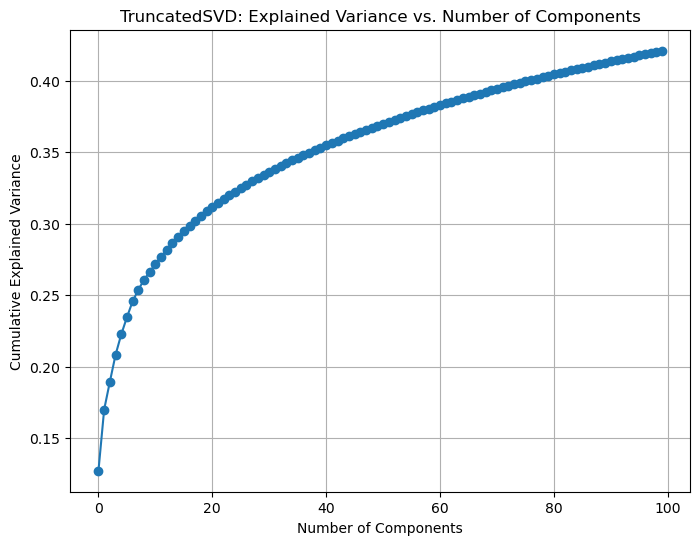

–û–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ —á–∏—Å–ª–æ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç (–¥–ª—è 90% –¥–∏—Å–ø–µ—Ä—Å–∏–∏): 1


In [9]:
# 3. –û–±—É—á–∞–µ–º SVD (–Ω–∞–ø—Ä–∏–º–µ—Ä, –Ω–∞ 100 –∫–æ–º–ø–æ–Ω–µ–Ω—Ç)
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(ratings_csr)

# –°—Ç—Ä–æ–∏–º –≥—Ä–∞—Ñ–∏–∫ –Ω–∞–∫–æ–ø–ª–µ–Ω–Ω–æ–π –æ–±—ä—è—Å–Ω—ë–Ω–Ω–æ–π –¥–∏—Å–ø–µ—Ä—Å–∏–∏
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('TruncatedSVD: Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"–û–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ —á–∏—Å–ª–æ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç (–¥–ª—è 90% –¥–∏—Å–ø–µ—Ä—Å–∏–∏): {optimal_components}")

In [10]:
print(svd.explained_variance_ratio_)
print("–°—É–º–º–∞—Ä–Ω–∞—è –æ–±—ä—è—Å–Ω—ë–Ω–Ω–∞—è –¥–∏—Å–ø–µ—Ä—Å–∏—è:", np.sum(svd.explained_variance_ratio_))

[0.12714636 0.04276994 0.01942166 0.01888211 0.01427642 0.01204105
 0.01111132 0.00813921 0.00688492 0.00561164 0.00556328 0.00504842
 0.00499753 0.00482021 0.00415399 0.00412725 0.00354825 0.00349691
 0.00343389 0.00312327 0.00294858 0.00289923 0.00272115 0.00262711
 0.00255894 0.00251541 0.00244757 0.0023686  0.00228196 0.00223389
 0.00218057 0.00207525 0.00202688 0.00194128 0.00189778 0.00185302
 0.00181357 0.00180561 0.00177047 0.00172587 0.00164498 0.00162621
 0.00158946 0.00158323 0.00155453 0.00153355 0.00148958 0.00145526
 0.00144528 0.00142085 0.00141285 0.00139891 0.00136401 0.00133629
 0.00131746 0.00130235 0.00127148 0.00125722 0.00124909 0.00122671
 0.0012125  0.00119395 0.00118462 0.00116325 0.00114765 0.00114455
 0.00113347 0.00111178 0.00110115 0.001098   0.00107721 0.00105896
 0.00104209 0.00103874 0.00103479 0.00101604 0.00099837 0.00098936
 0.00098634 0.00096874 0.0009544  0.0009436  0.000942   0.00093512
 0.00092453 0.00092108 0.0009146  0.00089845 0.00089131 0.0008

In [11]:
# 4 –ü—Ä–∏–º–µ–Ω—è–µ–º SVD –Ω–∞ –≤—ã–±—Ä–∞–Ω–æ–º –∫–æ–ª-–≤–µ –∫–æ–º–ø–æ–Ω–µ–Ω—Ç(TruncatedSVD)

svd = TruncatedSVD(n_components=50, random_state=42)
user_matrix = svd.fit_transform(ratings_csr)  # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å: (n_users √ó 50)
item_matrix = svd.components_.T                # —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å: (n_items √ó 50)

In [15]:
def get_svd_recommendations(user_id, user_encoder, item_encoder, svd_user_factors, svd_item_factors, movies, ratings, top_n=10):
    """
    –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π –¥–ª—è –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è –Ω–∞ –æ—Å–Ω–æ–≤–µ SVD.
    """
    try:
        user_idx = user_encoder.transform([user_id])[0]
    except ValueError:
        print(f"–ü–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å {user_id} –Ω–µ –Ω–∞–π–¥–µ–Ω.")
        return pd.DataFrame()

    user_vector = svd_user_factors[user_idx]  # shape: (50,)
    scores = np.dot(svd_item_factors, user_vector)  # shape: (n_items,)

    # –ü–æ–ª—É—á–∞–µ–º —É–∂–µ –ø—Ä–æ—Å–º–æ—Ç—Ä–µ–Ω–Ω—ã–µ —Ñ–∏–ª—å–º—ã
    rated_movie_ids = ratings[ratings['userId'] == user_id]['movieId'].unique()
    rated_item_indices = item_encoder.transform(rated_movie_ids)

    # –ò—Å–∫–ª—é—á–∞–µ–º –ø—Ä–æ—Å–º–æ—Ç—Ä–µ–Ω–Ω—ã–µ
    recommended_indices = [i for i in np.argsort(scores)[::-1] if i not in rated_item_indices][:top_n]

    # –î–µ–∫–æ–¥–∏—Ä—É–µ–º –≤ –æ—Ä–∏–≥–∏–Ω–∞–ª—å–Ω—ã–µ movieId
    recommended_movie_ids = item_encoder.inverse_transform(recommended_indices)

    # –°–æ–∑–¥–∞–µ–º DataFrame
    recommended_df = pd.DataFrame(recommended_movie_ids, columns=['movieId'])
    recommended_df = recommended_df.merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left')

    return recommended_df


In [16]:
recommended_df = get_svd_recommendations(
    user_id='1',                              # –∏–ª–∏ –ª—é–±–æ–π –¥—Ä—É–≥–æ–π userId –∏–∑ original ratings
    user_encoder=user_encoder,
    item_encoder=item_encoder,
    svd_user_factors=user_matrix,            # user-—Ñ–∞–∫—Ç–æ—Ä—ã: (n_users, 50)
    svd_item_factors=item_matrix,            # item-—Ñ–∞–∫—Ç–æ—Ä—ã: (n_items, 50)
    movies=movies,                           # DataFrame —Å —Ñ–∏–ª—å–º–∞–º–∏
    ratings=ratings,                         # –¥–ª—è —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏ —É–∂–µ –æ—Ü–µ–Ω–µ–Ω–Ω—ã—Ö —Ñ–∏–ª—å–º–æ–≤
    top_n=10
)
recommended_df

movieId  ...                          genres
0     4993  ...               Adventure|Fantasy
1     7153  ...  Action|Adventure|Drama|Fantasy
2     5952  ...               Adventure|Fantasy
3      110  ...                Action|Drama|War
4      260  ...         Action|Adventure|Sci-Fi
5     1196  ...         Action|Adventure|Sci-Fi
6     1210  ...         Action|Adventure|Sci-Fi
7      356  ...        Comedy|Drama|Romance|War
8     2028  ...                Action|Drama|War
9     2571  ...          Action|Sci-Fi|Thriller

[10 rows x 3 columns]

## Hdbscan

In [23]:
hdbscan_model = HDBSCAN(min_samples=20, cluster_selection_epsilon=0.01)  # –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –º–æ–∂–Ω–æ –Ω–∞—Å—Ç—Ä–æ–∏—Ç—å
clusters_hdb = hdbscan_model.fit_predict(movie_vectors_reduced)

In [24]:
unique_labels = np.unique(clusters_hdb)
num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # –ò—Å–∫–ª—é—á–∞–µ–º –≤—ã–±—Ä–æ—Å—ã (-1)
num_outliers = np.sum(clusters_hdb == -1)

print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤: {num_clusters}")
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤: {num_outliers}")

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤: 2
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤: 11285
